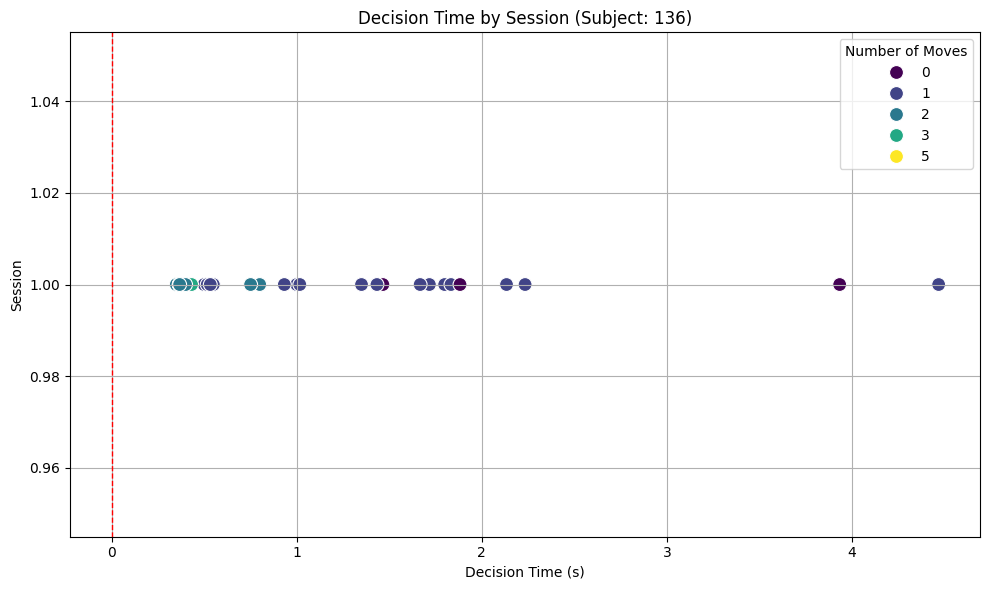

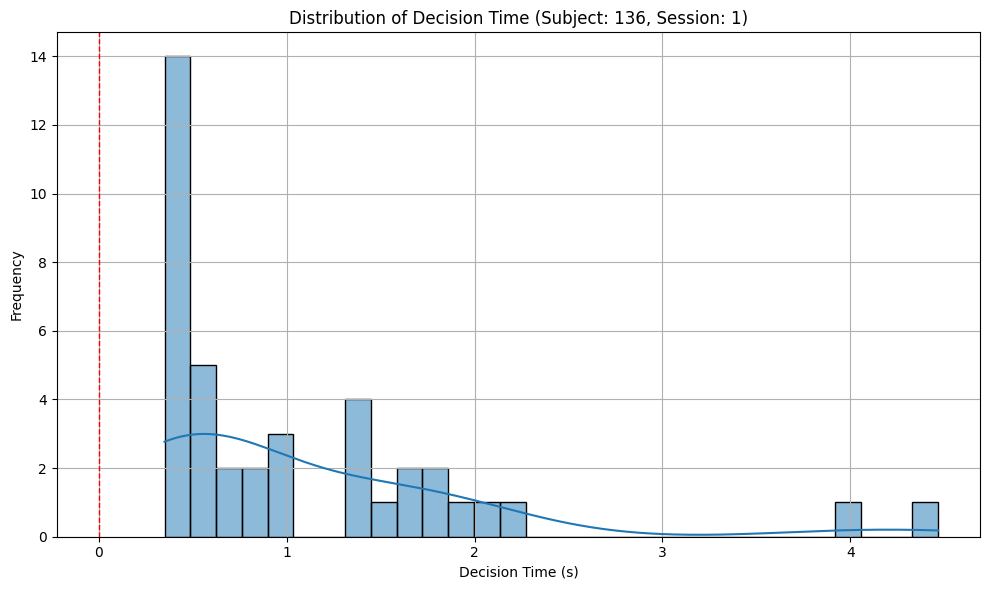

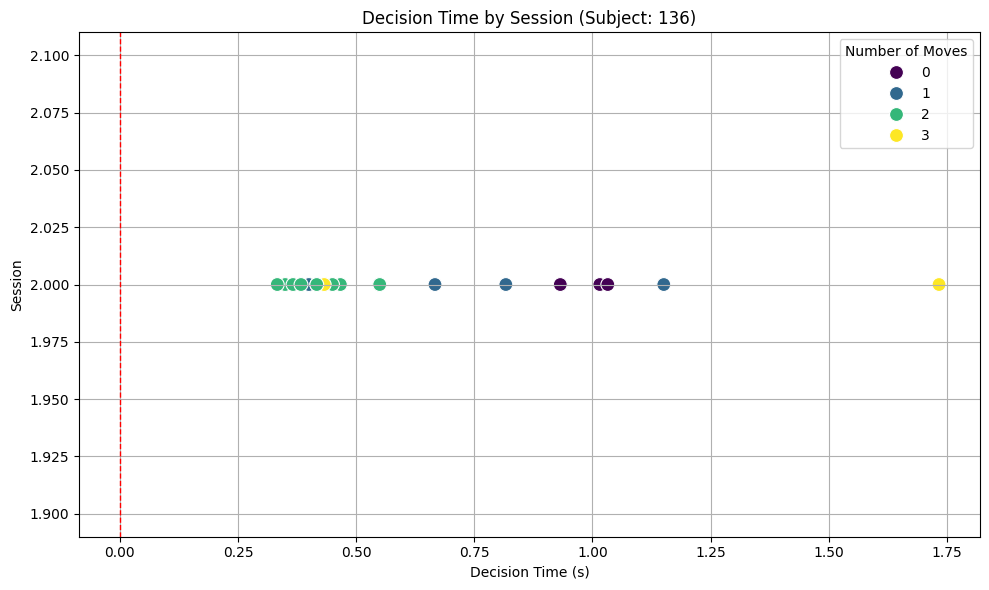

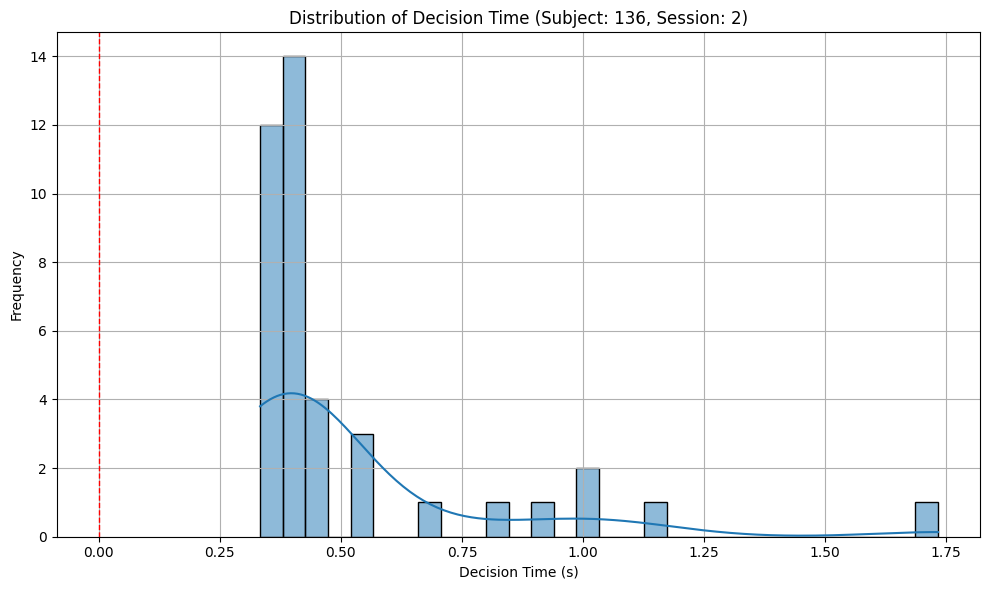

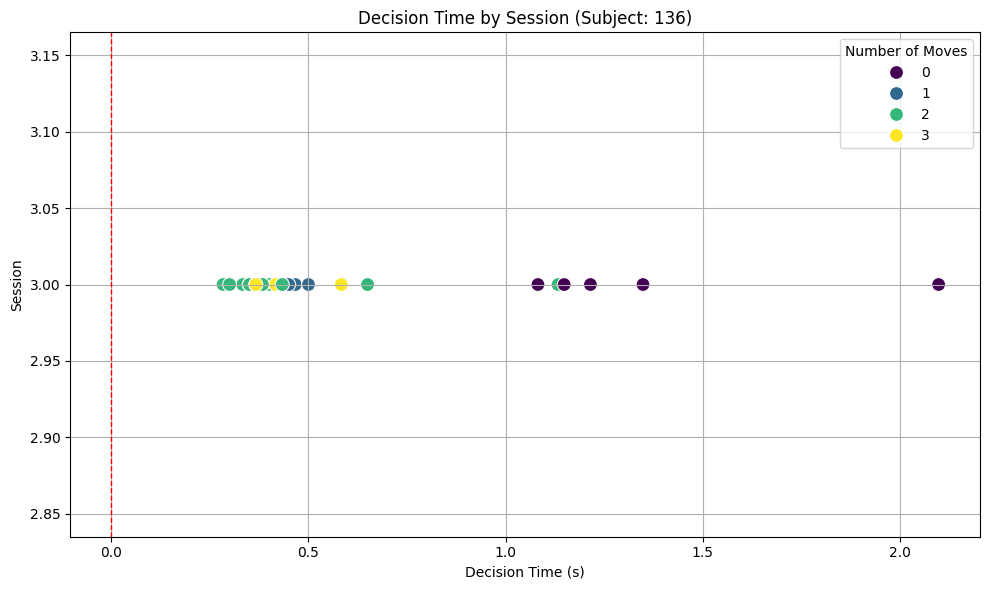

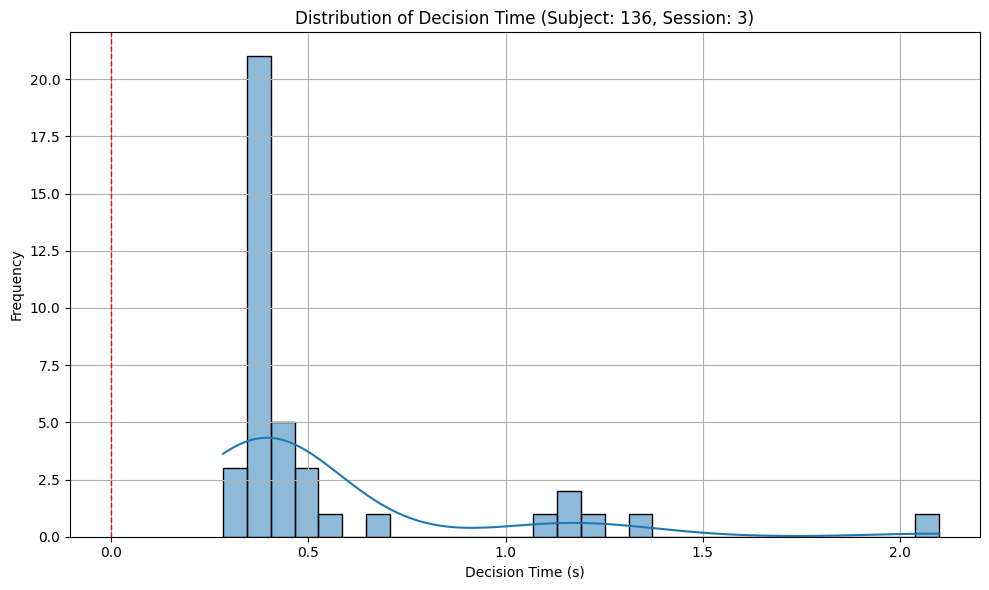

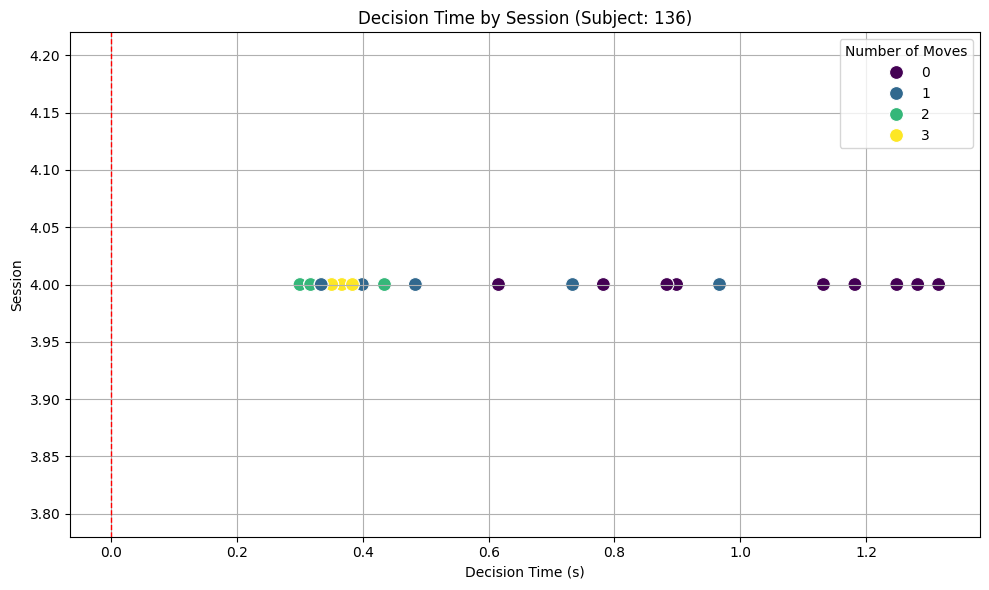

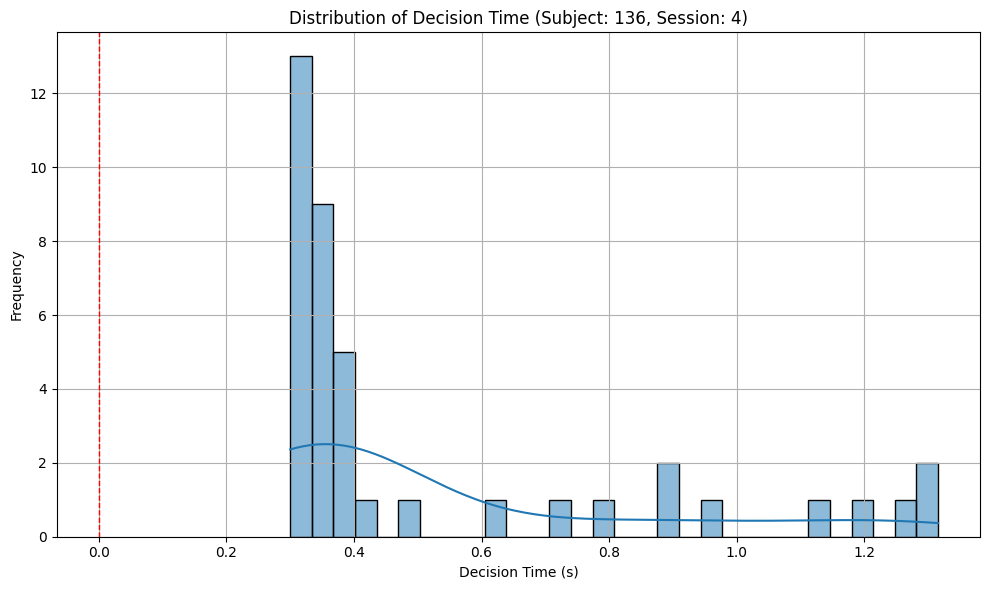

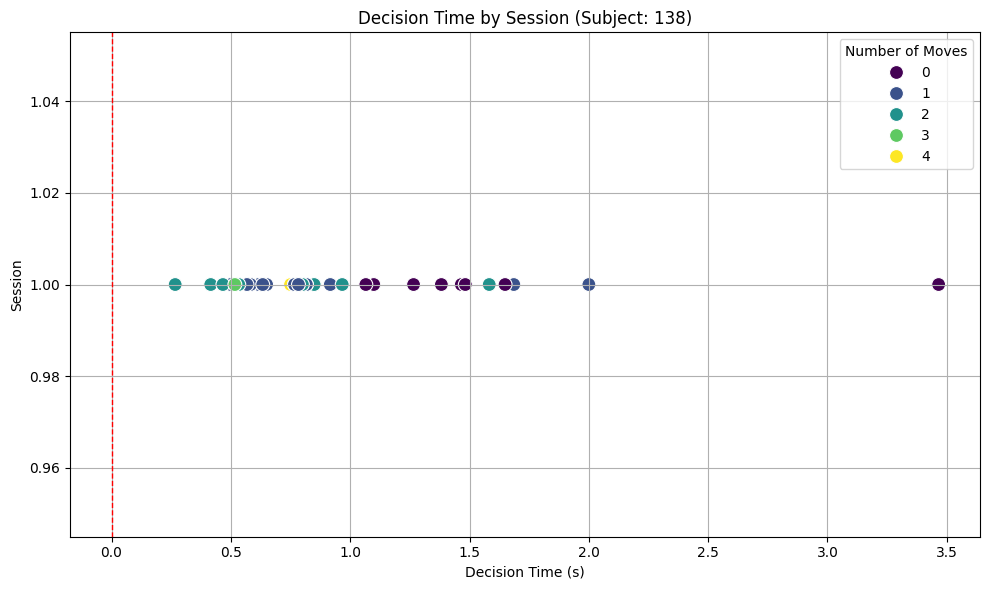

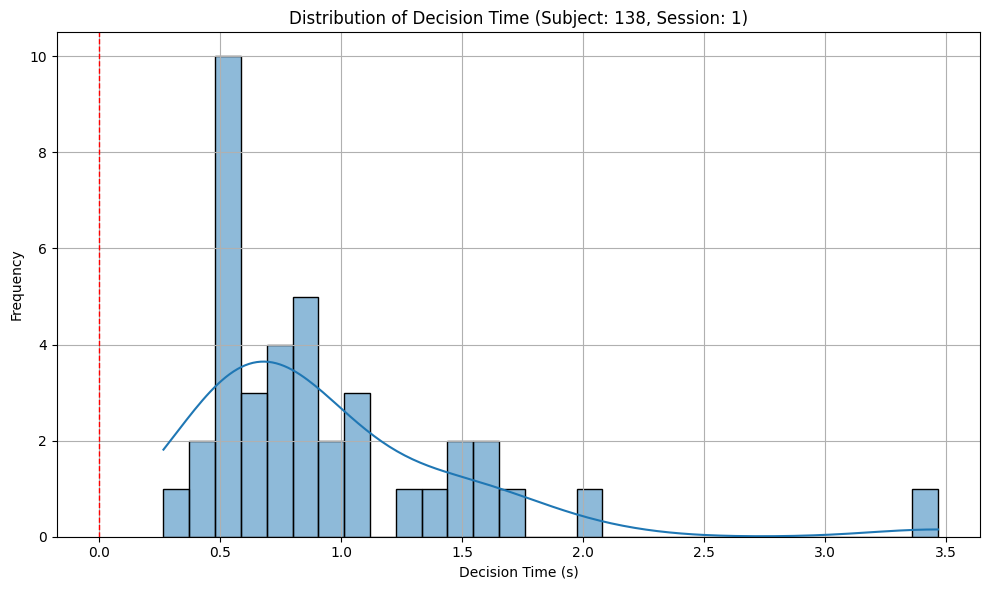

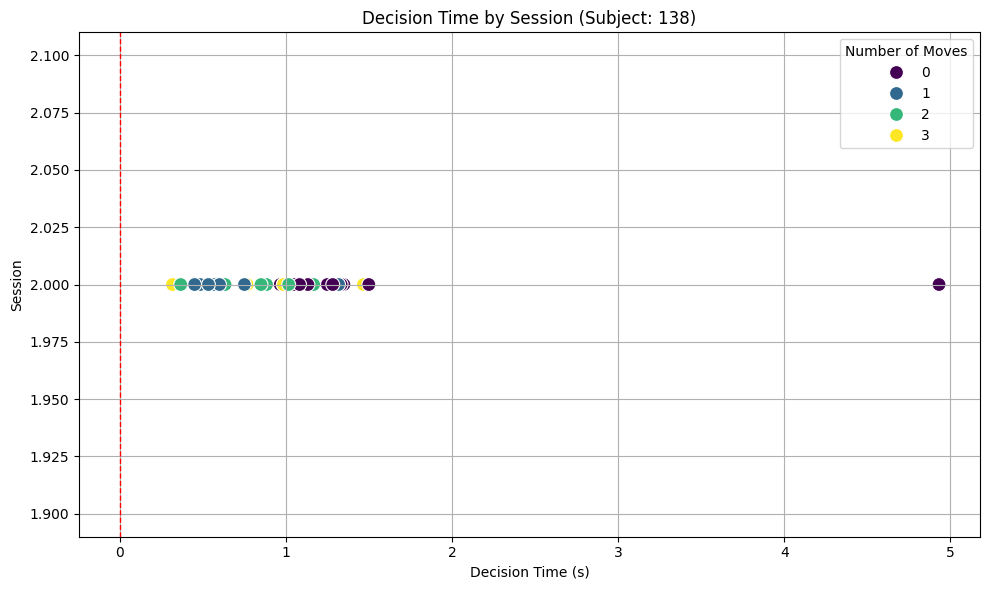

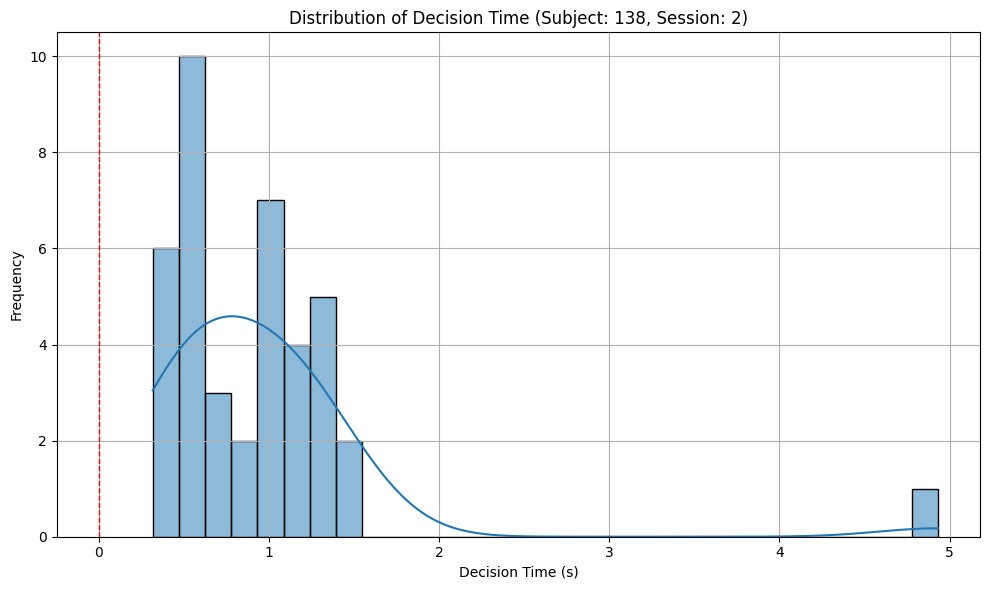

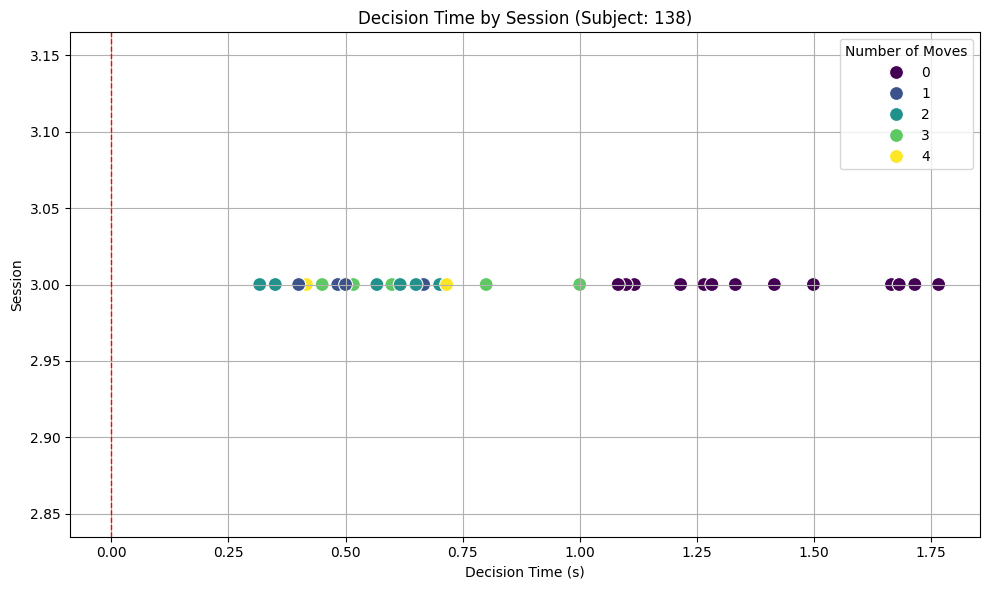

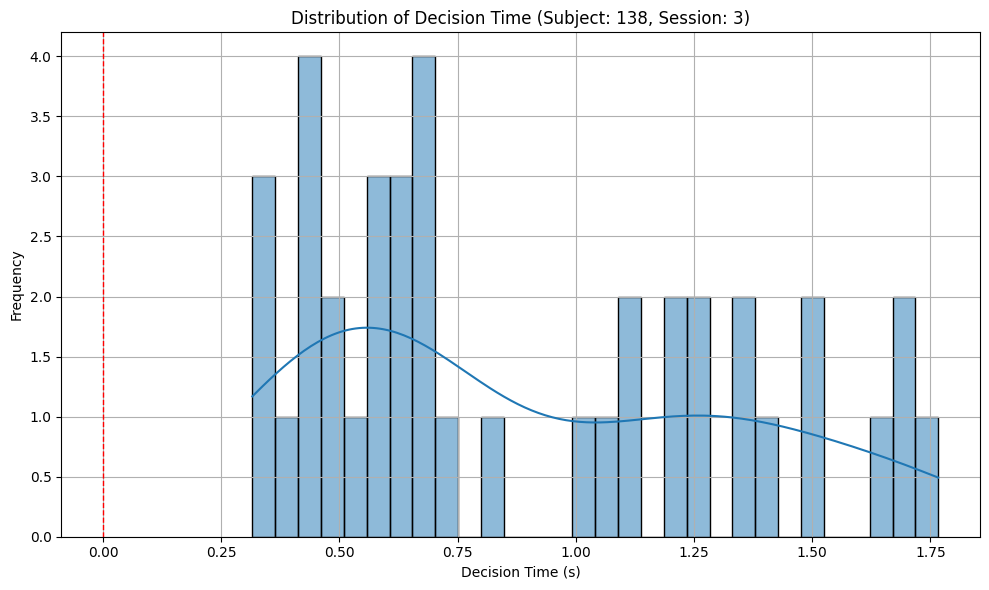

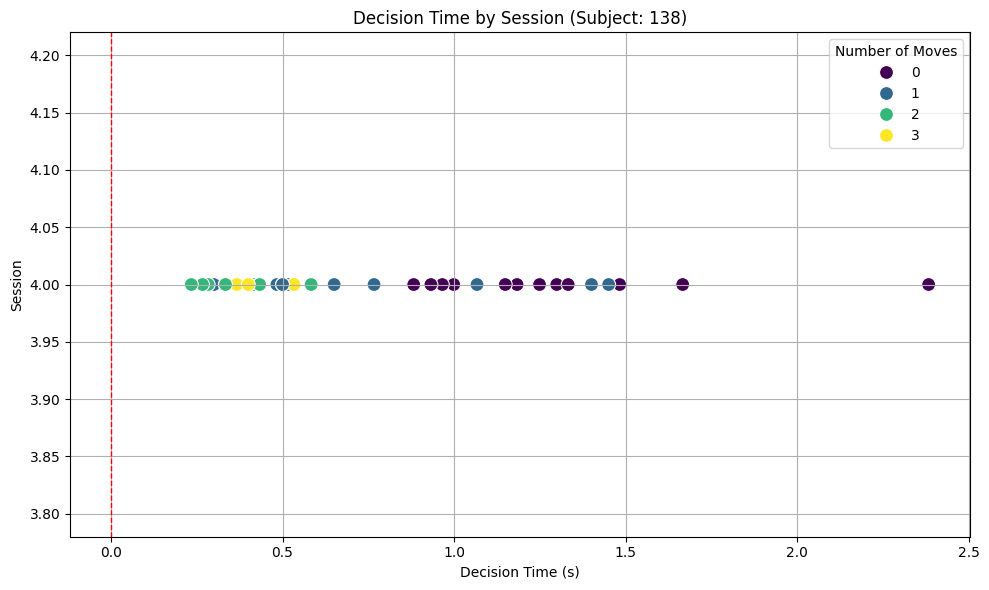

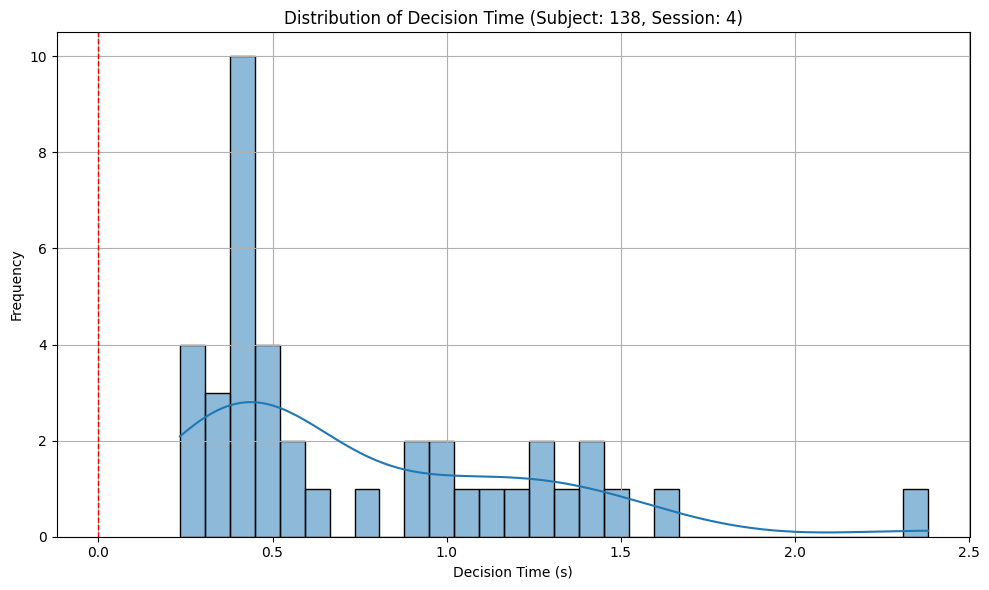

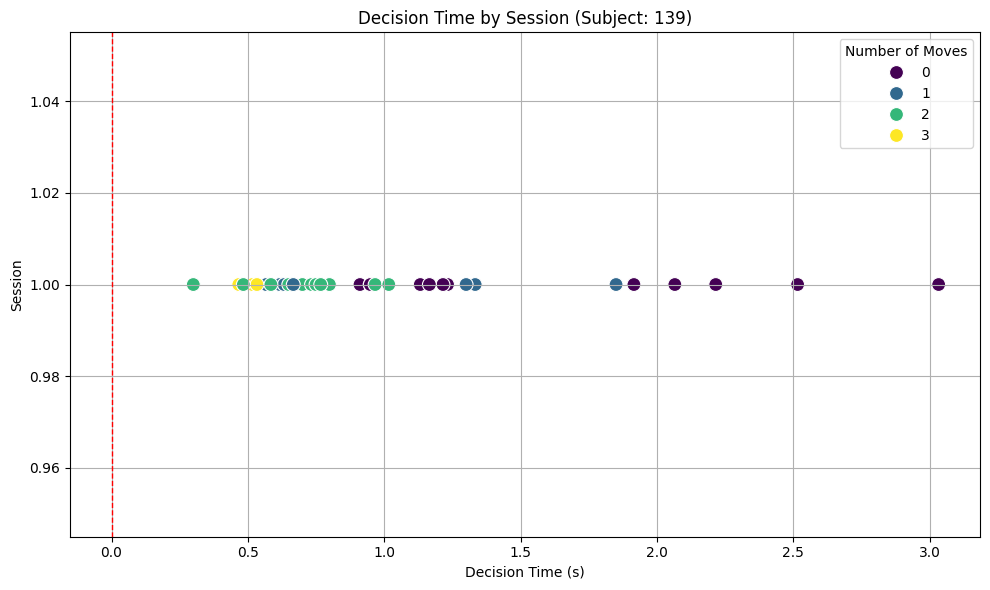

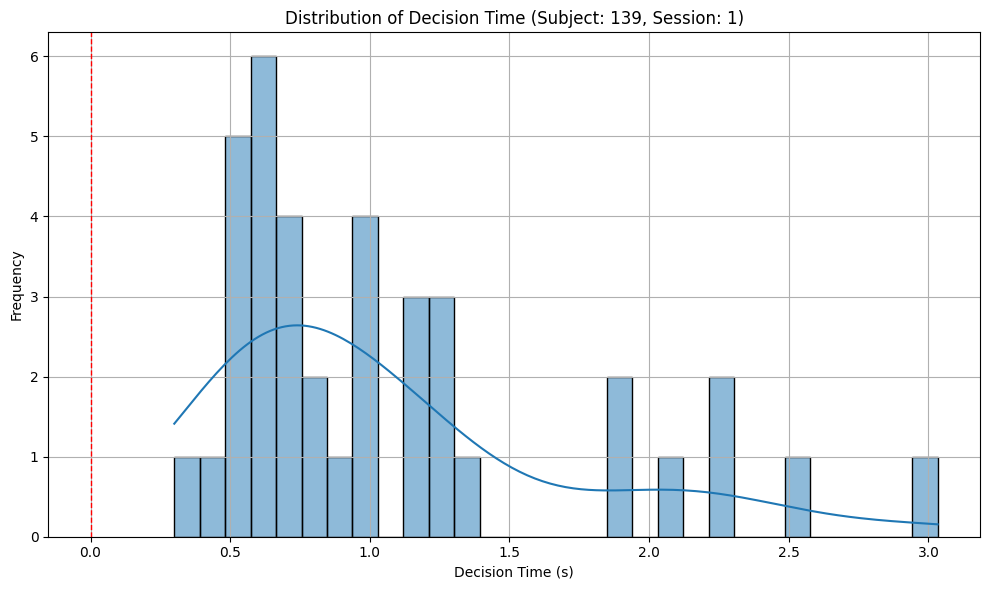

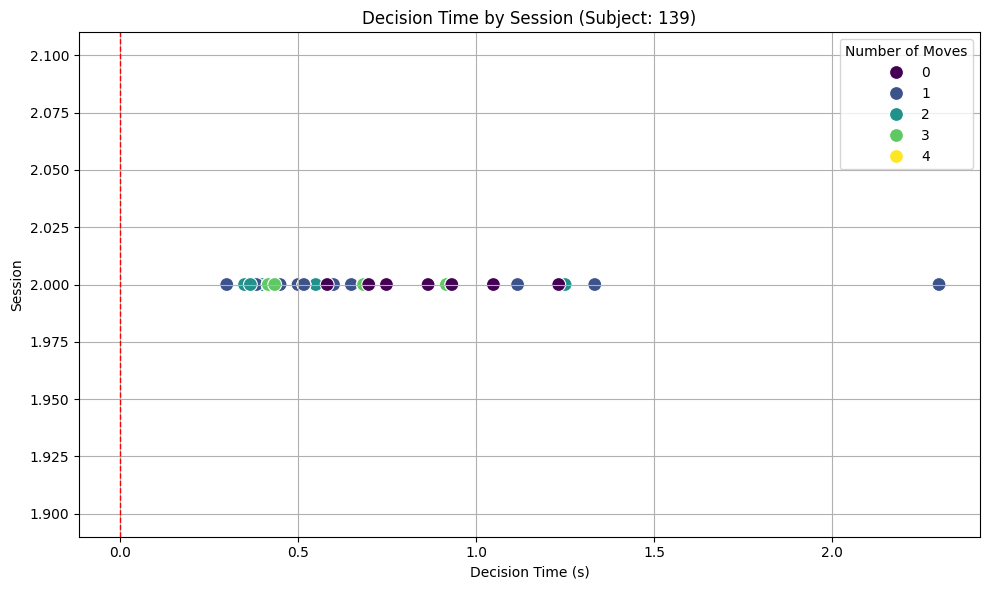

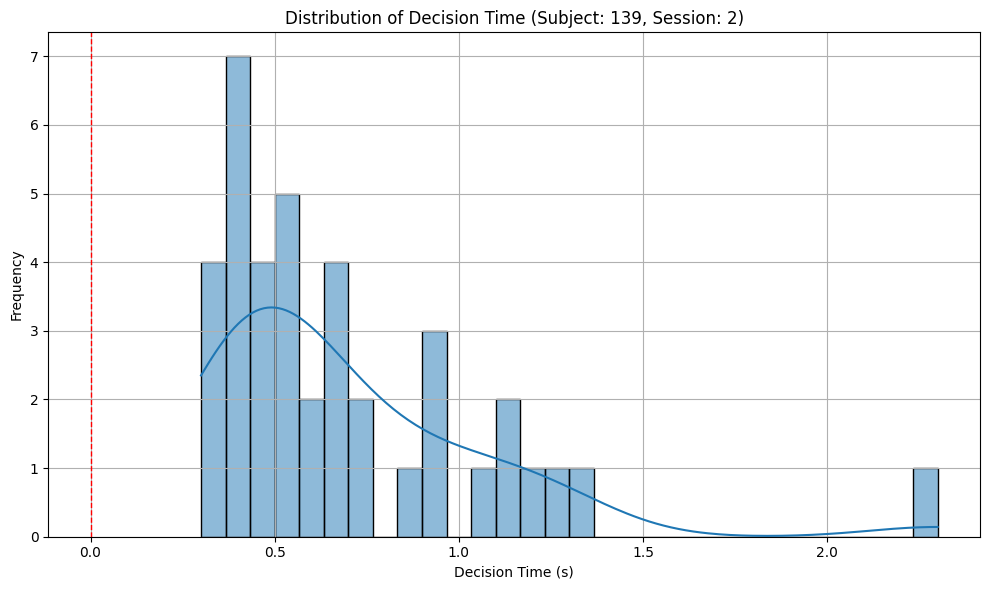

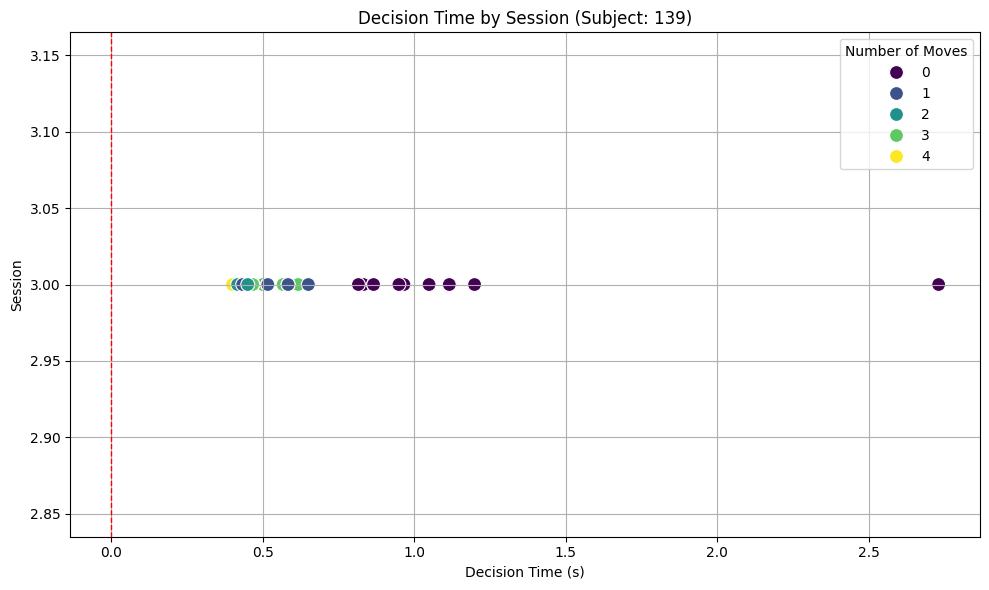

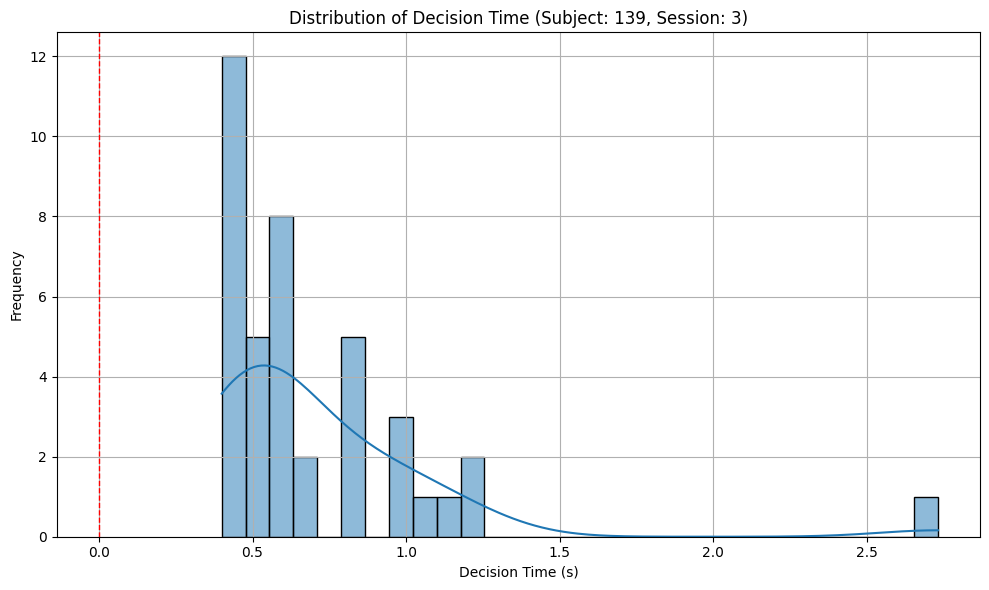

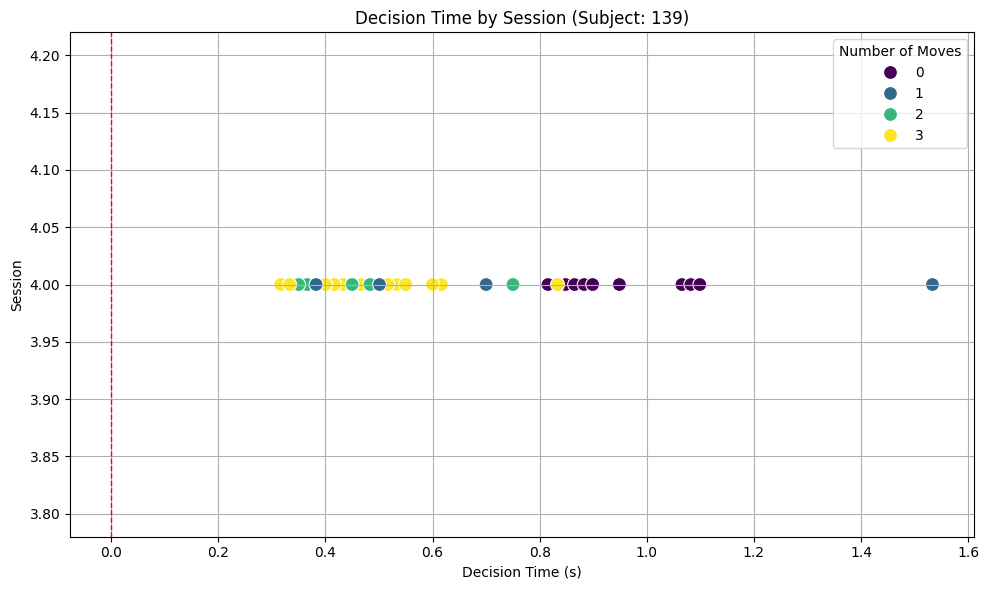

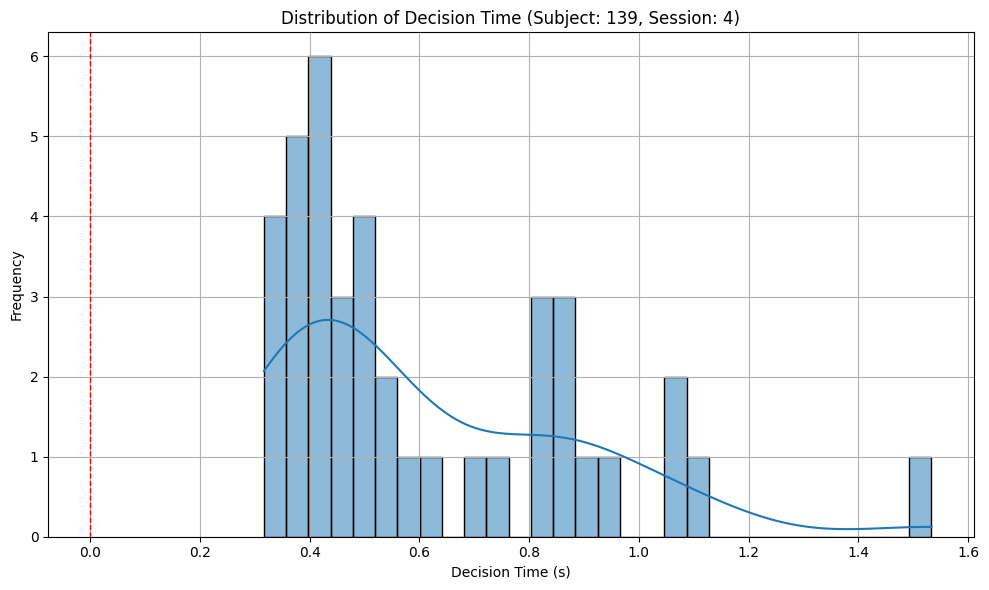

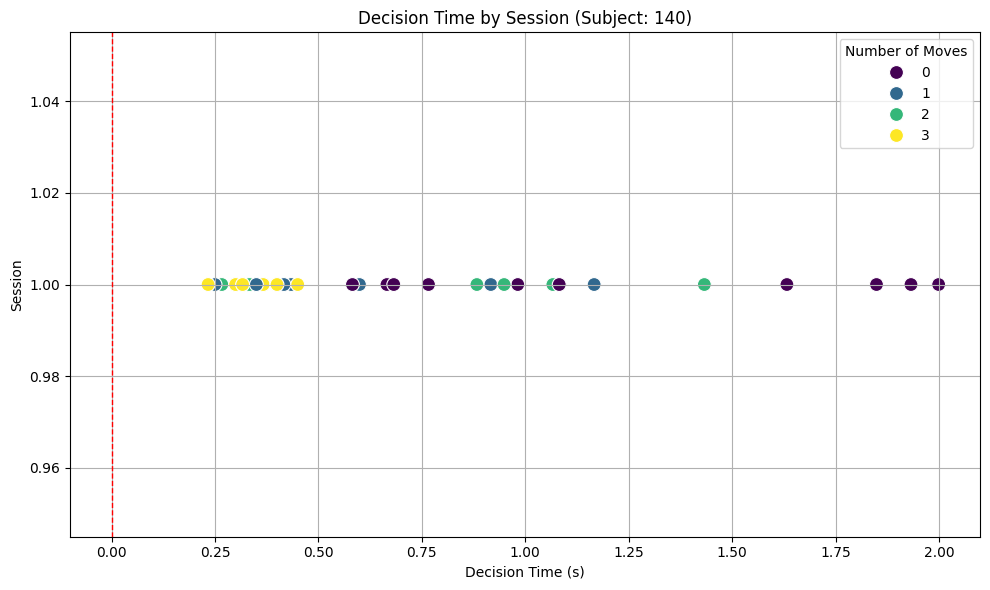

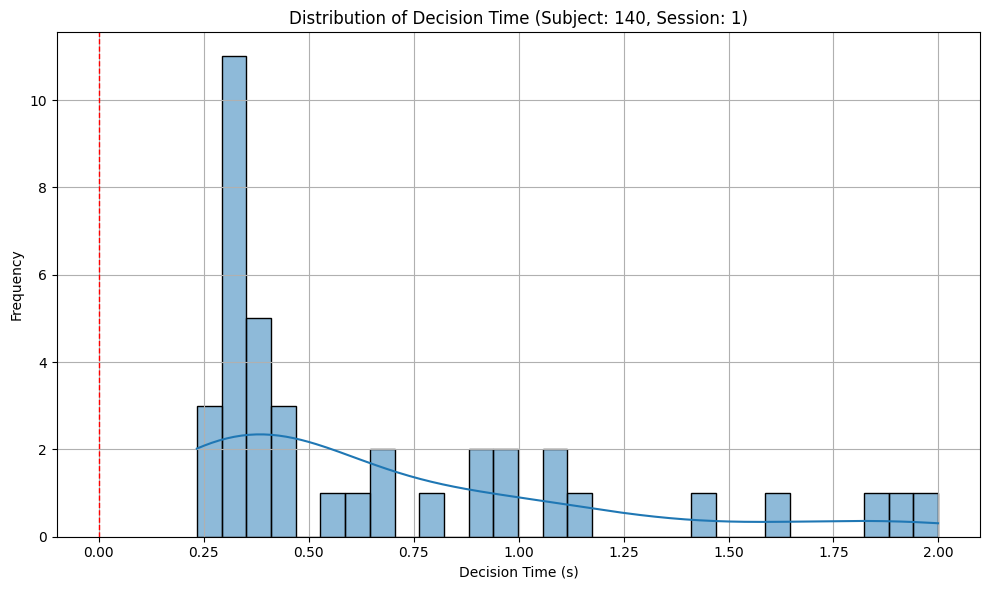

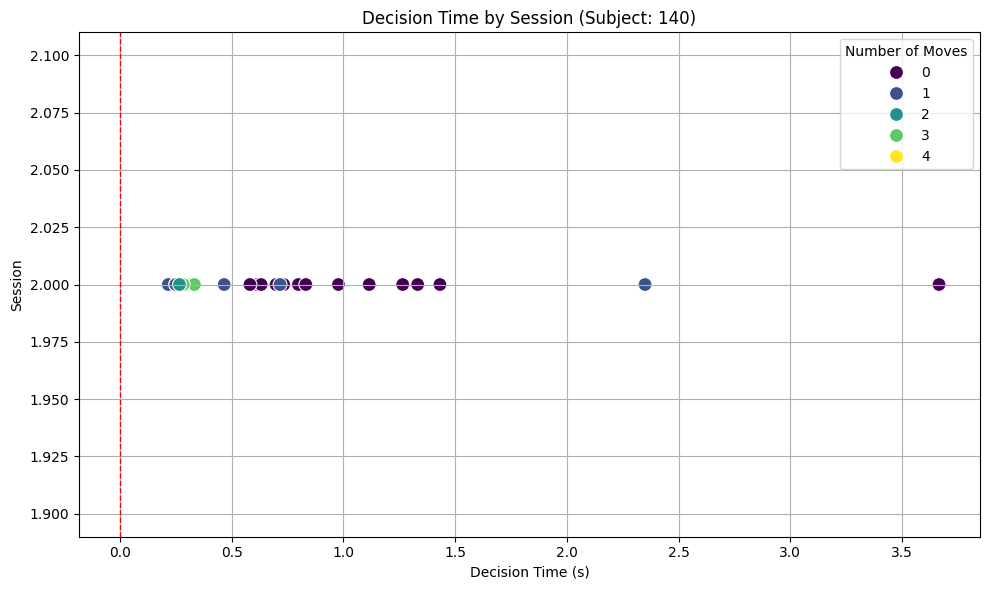

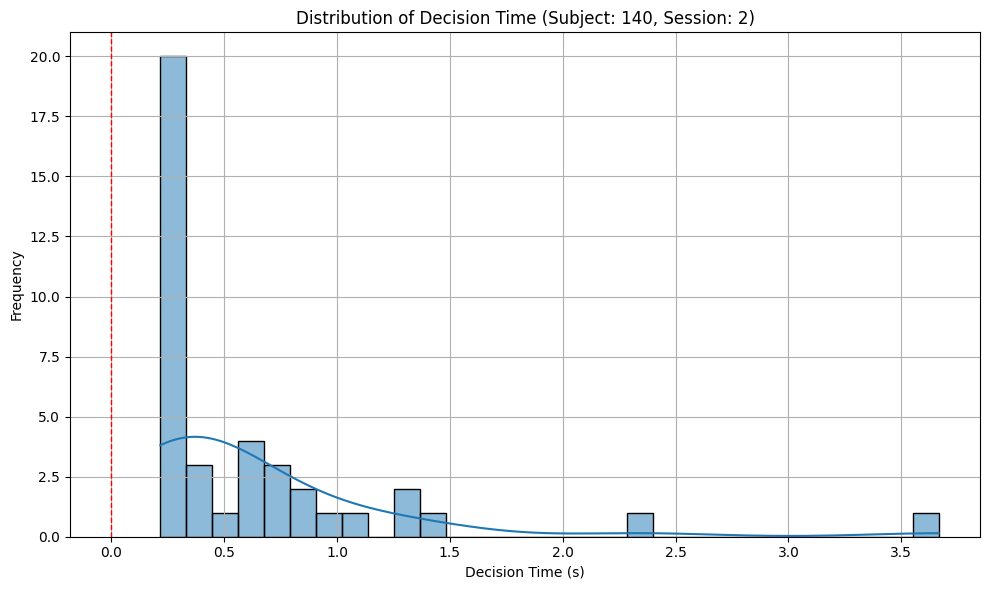

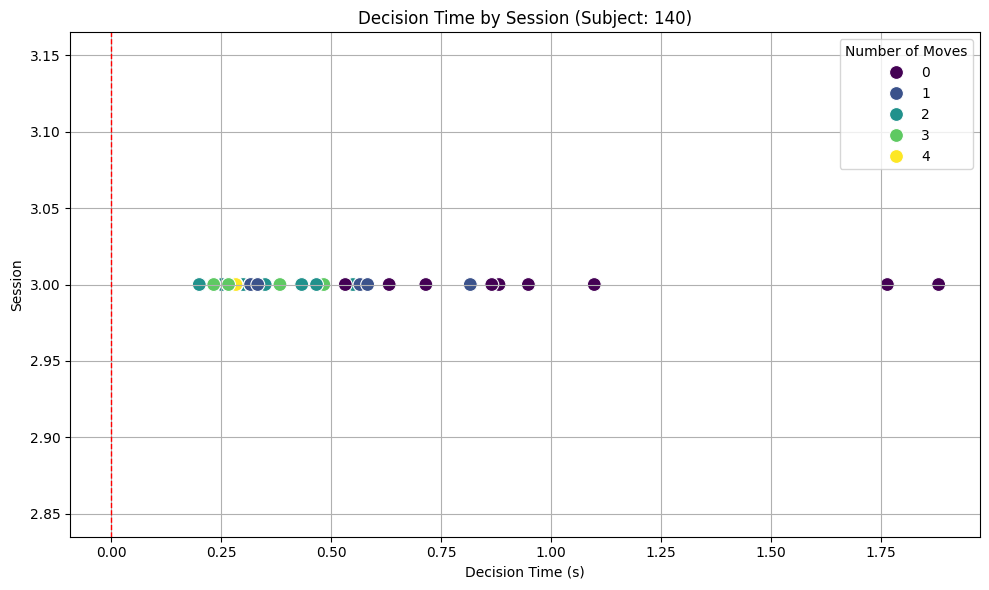

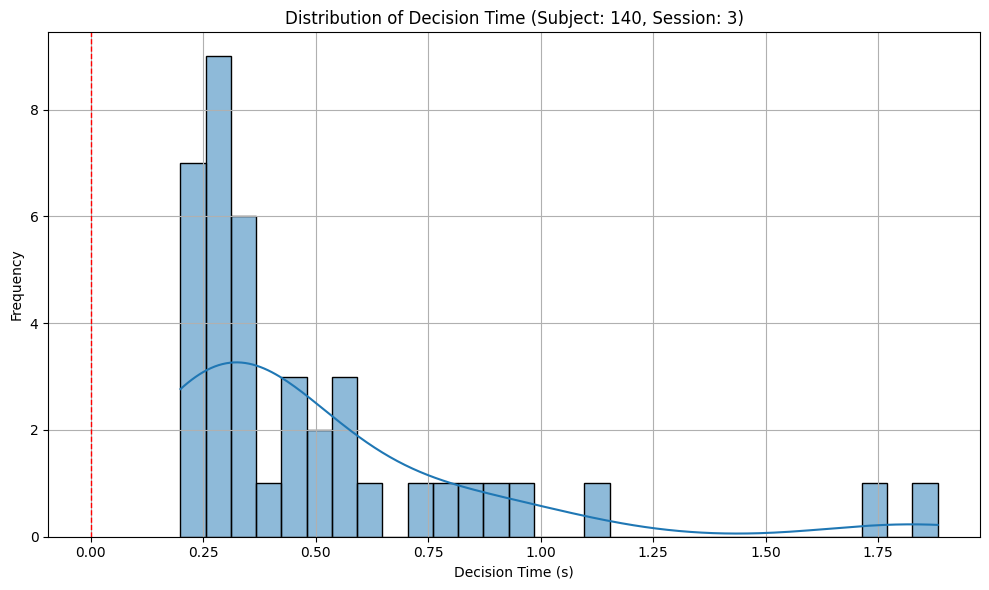

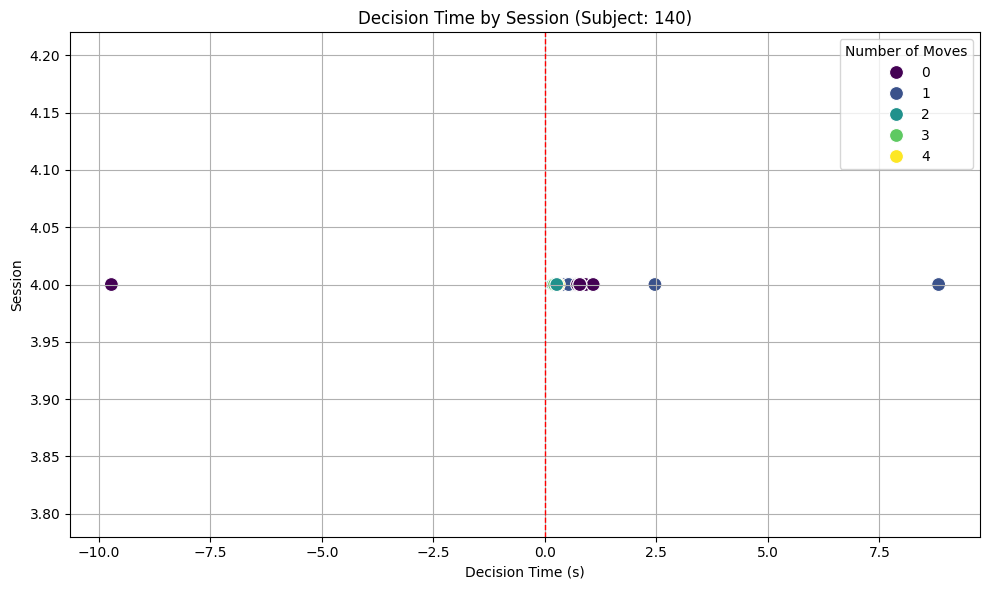

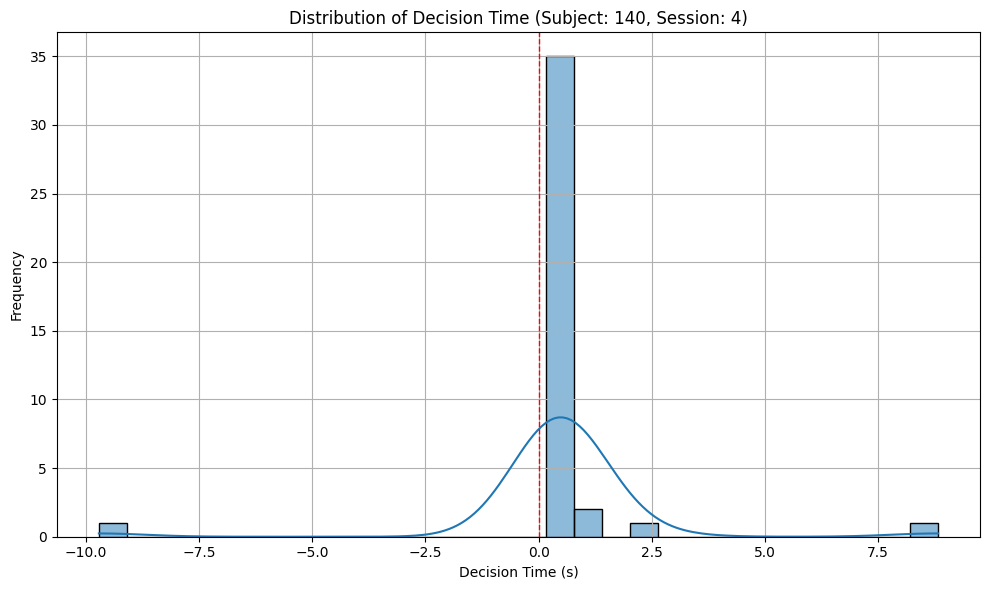

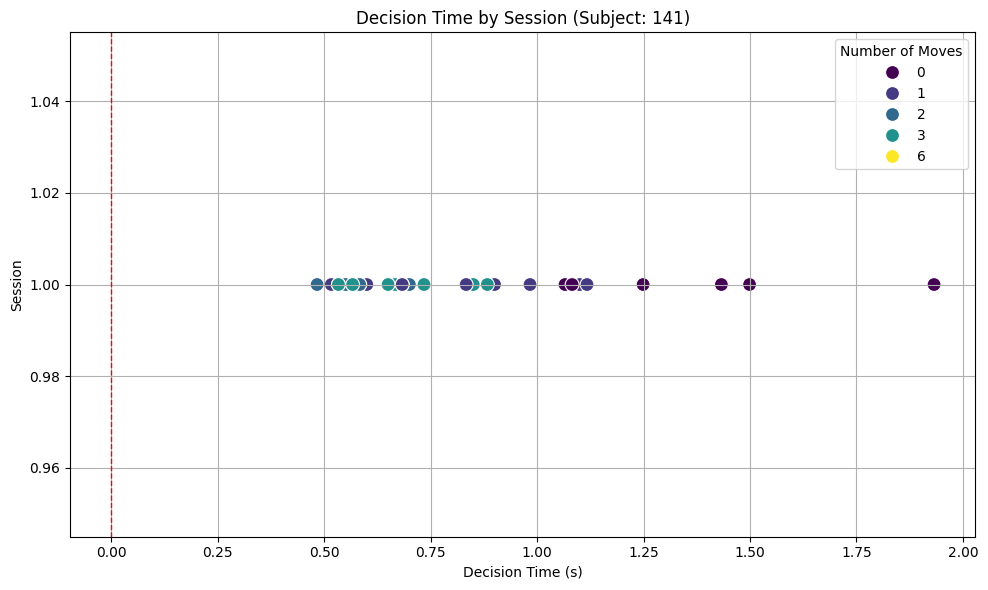

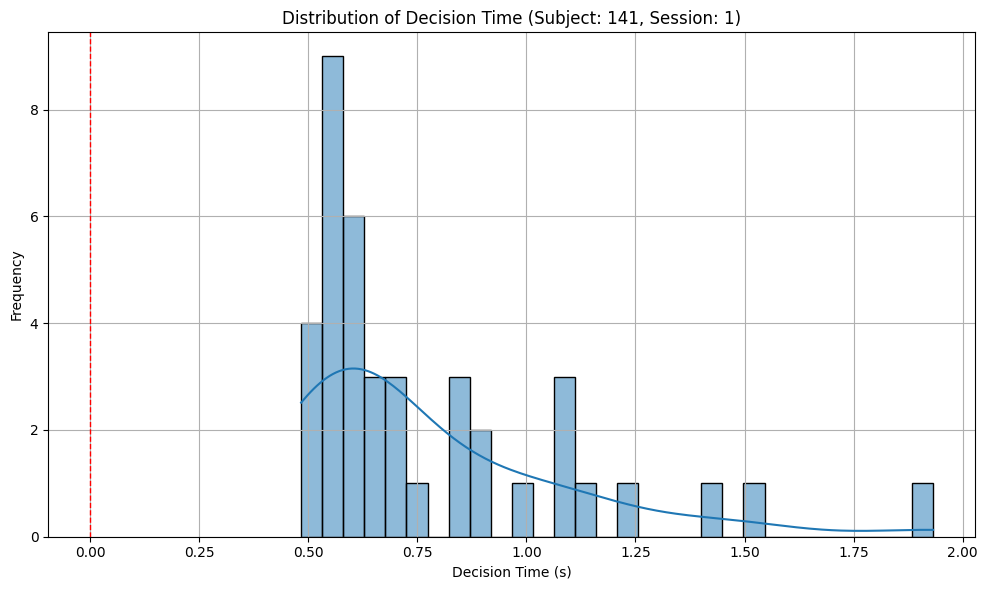

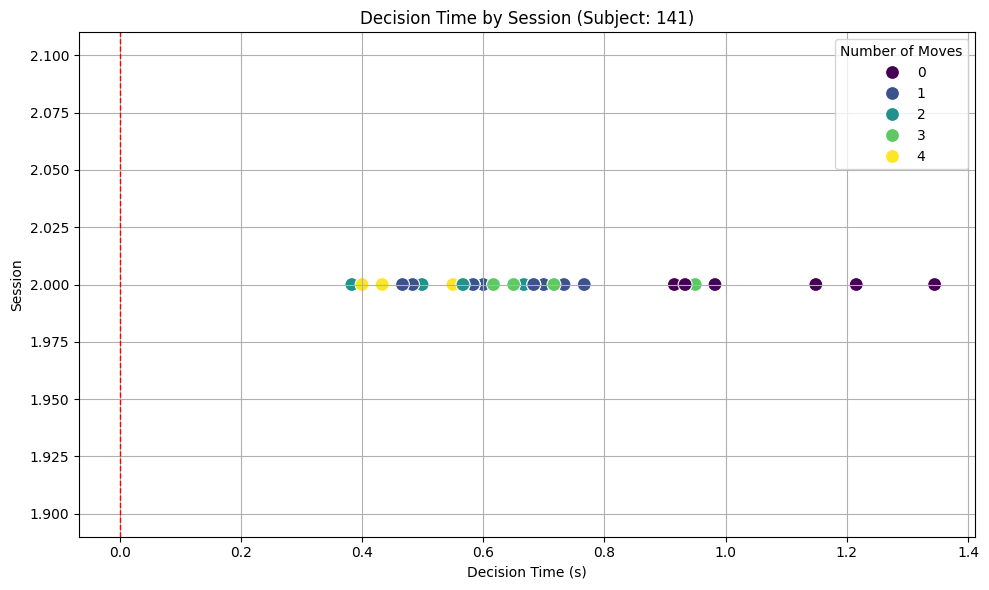

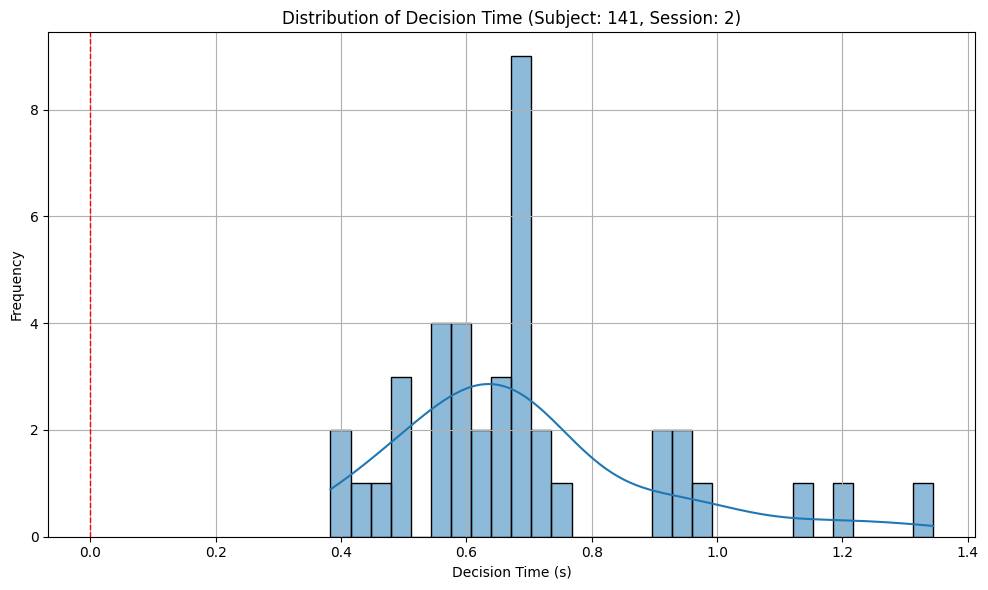

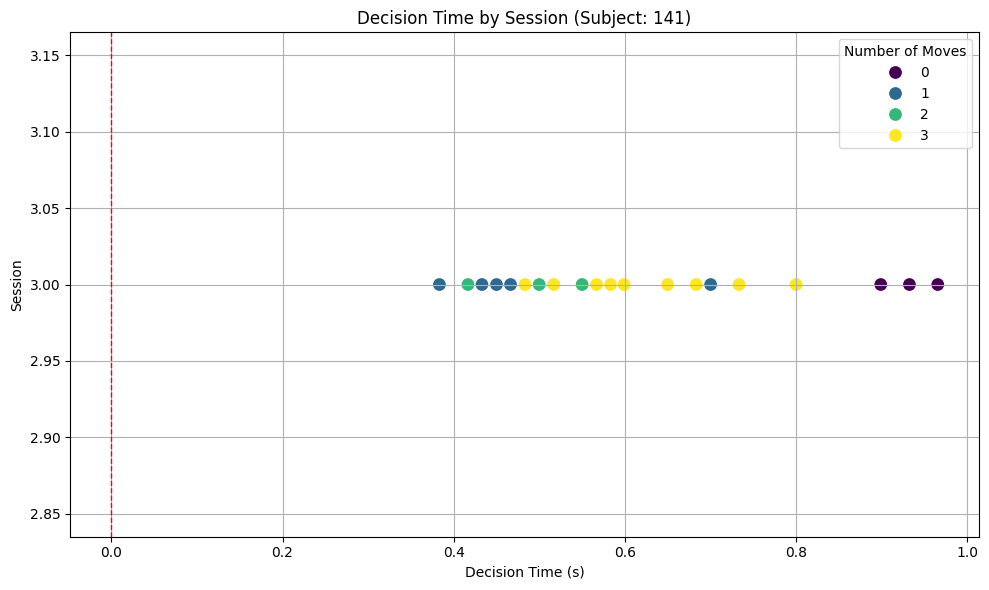

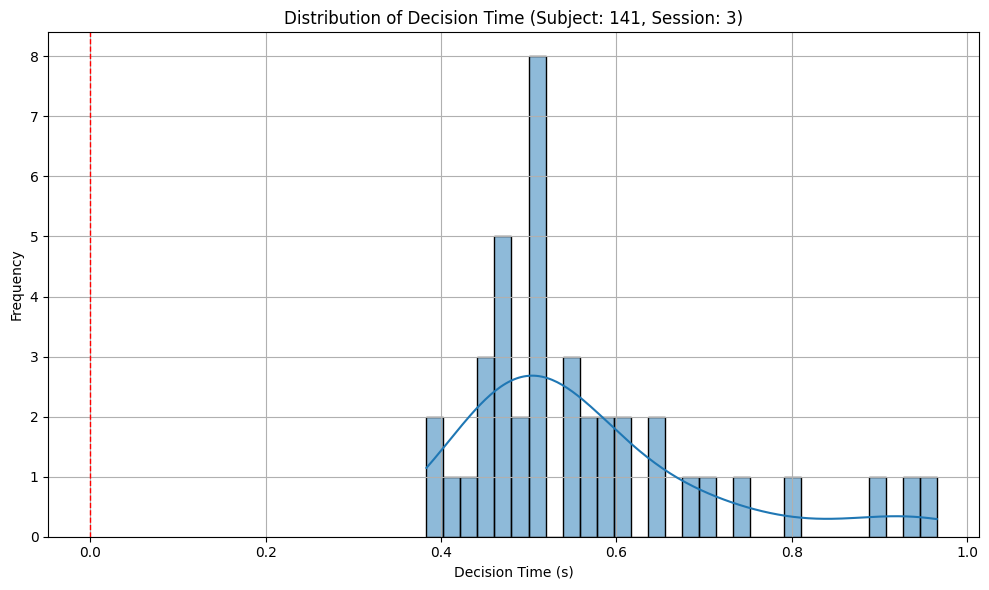

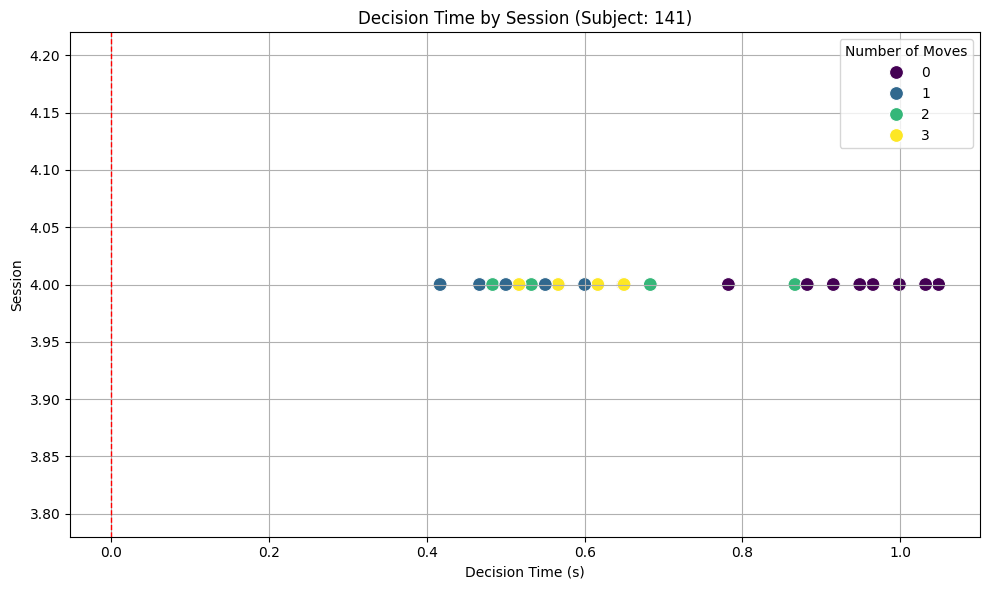

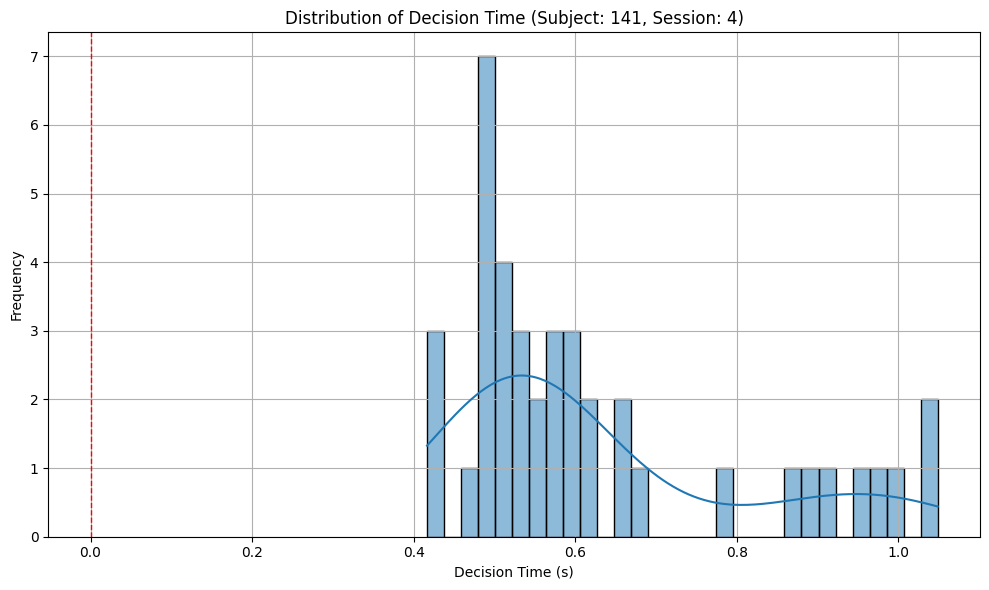

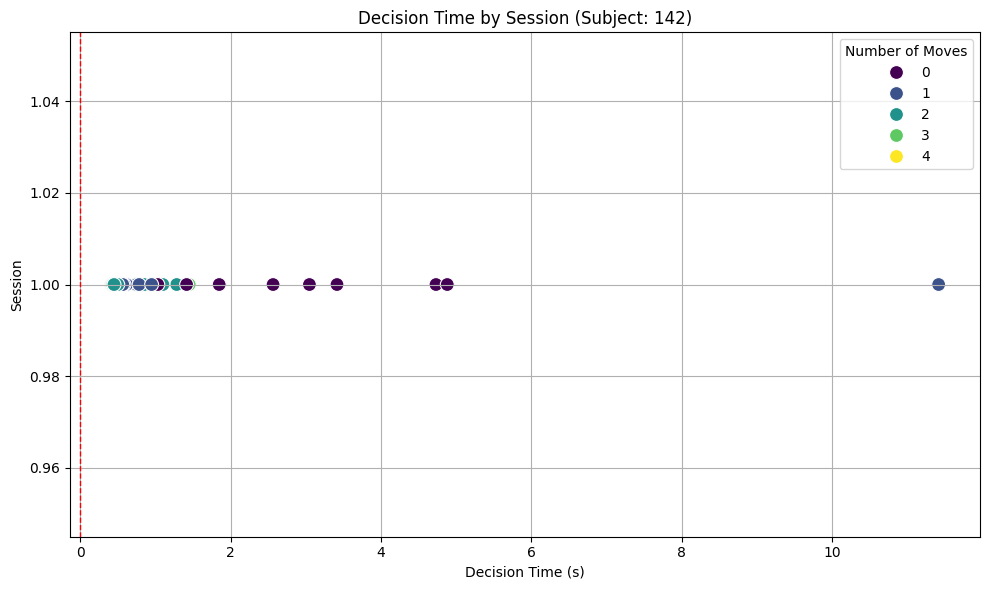

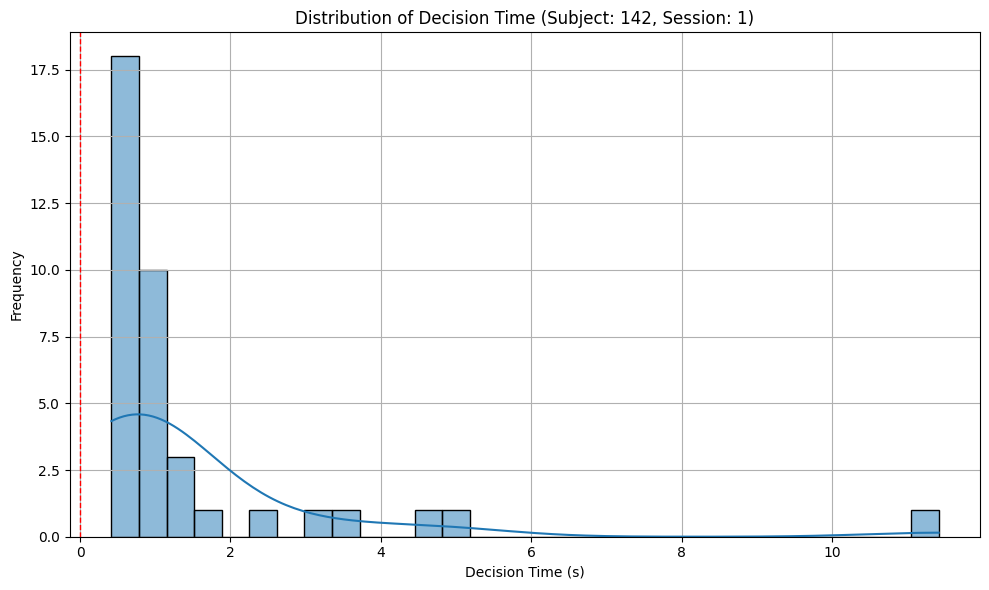

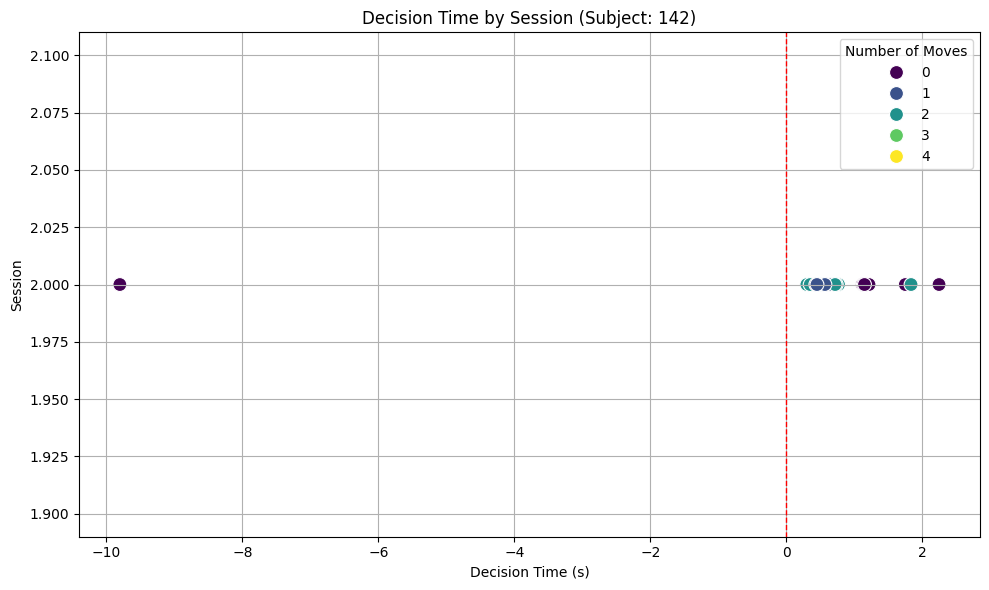

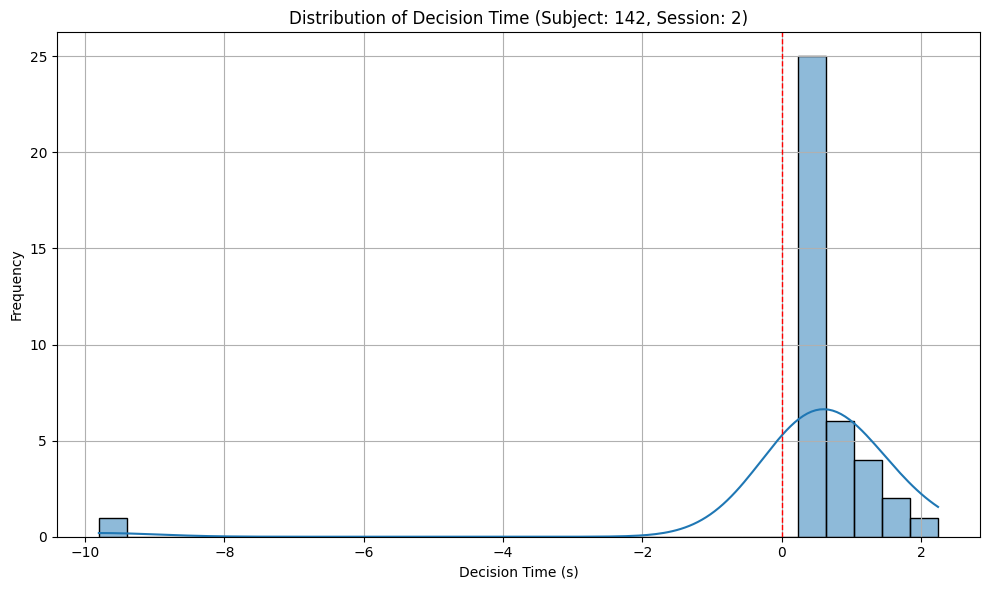

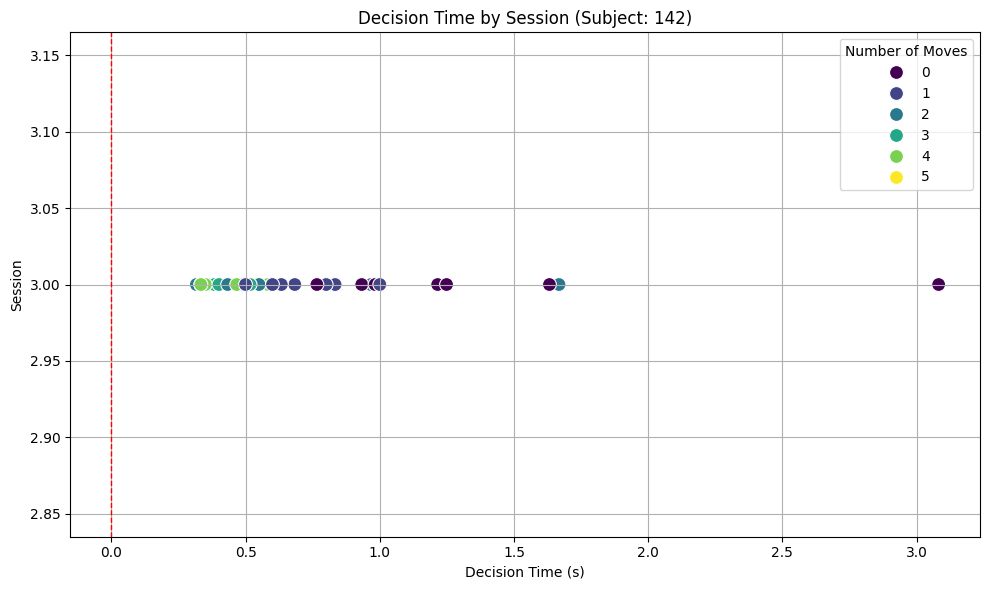

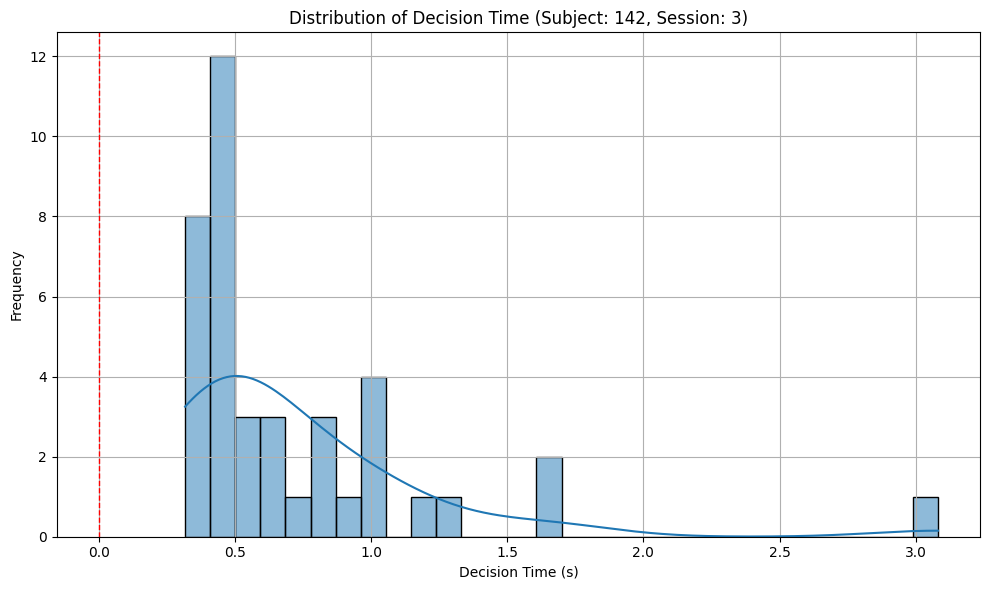

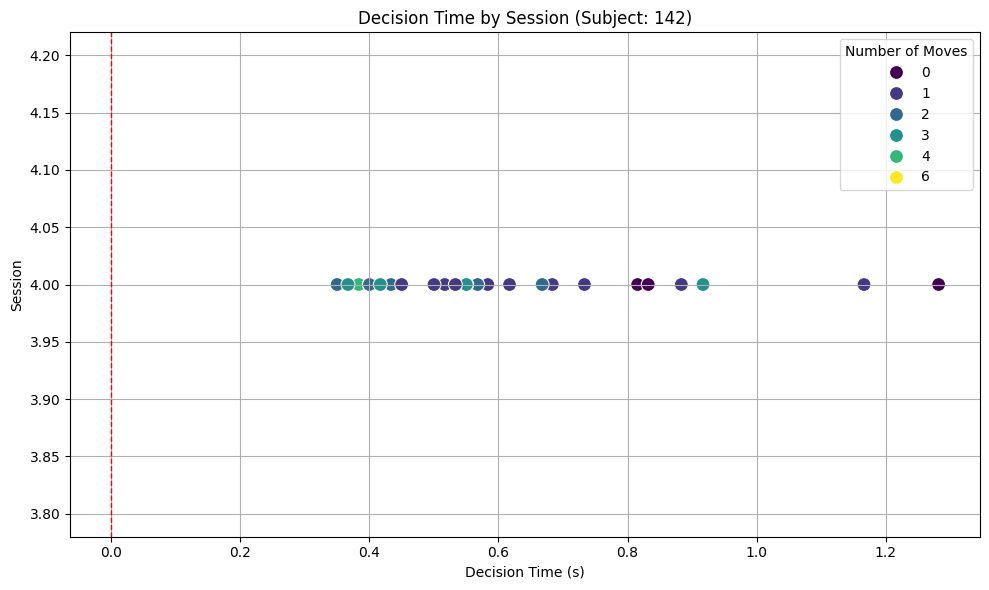

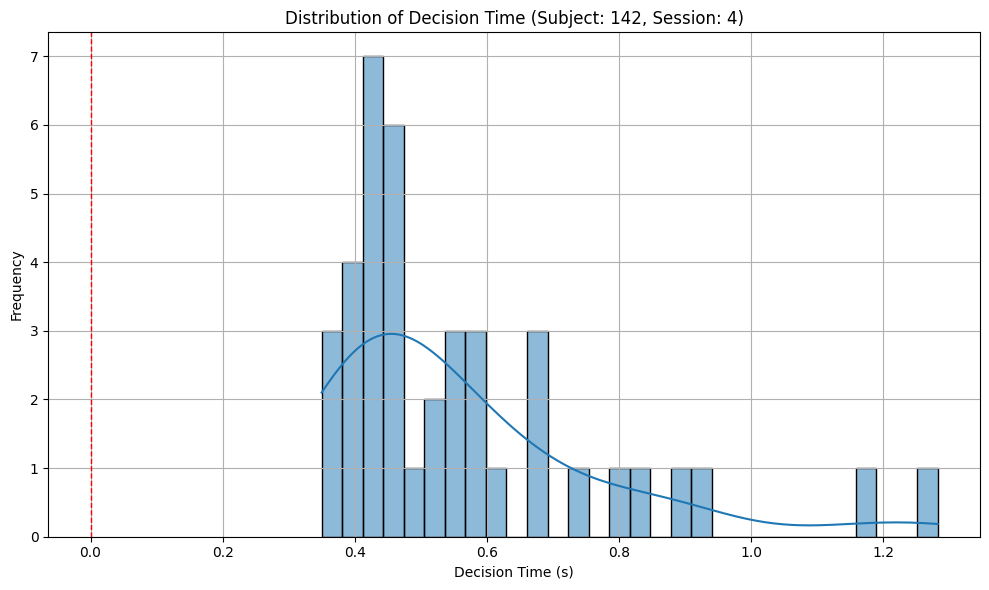

In [12]:
import os
import subprocess
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Install any missing packages
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

try:
    import statsmodels.api as sm
except ImportError:
    install('statsmodels')
    import statsmodels.api as sm

# Define the file path for df-1.csv and load the data
file_path = '/work/student_folders/markus_folder/df_1.csv'
df_1 = pd.read_csv(file_path)

# Convert t_moves to lists if it's a string representation
df_1['t_moves'] = df_1['t_moves'].apply(eval)

# Initialize a new column for decision time
df_1['decision_time'] = None

# Process data for decision time based on move count
for index, row in df_1.iterrows():
    if row['n_moves'] == 0:
        df_1.at[index, 'decision_time'] = row['rt_select']
    elif row['n_moves'] == 1:
        df_1.at[index, 'decision_time'] = row['rt_select'] - (row['t_moves'][0] - row['onset_decks'])
    elif row['n_moves'] > 1:
        df_1.at[index, 'decision_time'] = row['rt_select'] - (max(row['t_moves']) - row['onset_decks'])

# Filter out decision_time values greater than 150 seconds
df_1 = df_1[df_1['decision_time'] <= 150]

# Select only the relevant columns for exporting
# Include rt_select, t_moves, and onset_decks
plot_data = df_1[['subject_id', 'session', 'n_moves', 'rt_select', 't_moves', 'onset_decks', 'decision_time']]

# Save the filtered DataFrame to 'decision_time.csv' in the same directory as df-1.csv
output_file_path = os.path.join(os.path.dirname(file_path), 'decision_time.csv')
plot_data.to_csv(output_file_path, index=False)

# Plotting decision time by session with decision_time on the x-axis
grouped = plot_data.groupby(['subject_id', 'session'])

for (subject_id, session), group_df in grouped:
    plt.figure(figsize=(10, 6))
    
    # Scatter plot with decision_time on the x-axis
    sns.scatterplot(data=group_df, x='decision_time', y='session', hue='n_moves', palette='viridis', s=100)
    plt.title(f'Decision Time by Session (Subject: {subject_id})')
    plt.xlabel('Decision Time (s)')
    plt.ylabel('Session')
    plt.axvline(0, color='red', linestyle='--', linewidth=1)  # Reference line at 0 for decision_time
    plt.grid()
    plt.legend(title='Number of Moves')
    plt.tight_layout()
    plt.show()

    # Histogram of decision times for this subject and session
    plt.figure(figsize=(10, 6))
    sns.histplot(group_df['decision_time'], bins=30, kde=True)
    plt.title(f'Distribution of Decision Time (Subject: {subject_id}, Session: {session})')
    plt.xlabel('Decision Time (s)')
    plt.ylabel('Frequency')
    plt.axvline(0, color='red', linestyle='--', linewidth=1)  # Reference line at 0
    plt.grid()
    plt.tight_layout()
    plt.show()


In [17]:
import pandas as pd
import os

# Load the decision time data
decision_time_path = '/work/student_folders/markus_folder/decision_time.csv'
decision_time_df = pd.read_csv(decision_time_path)

# Load the switch frequency data
switch_df_path = '/work/student_folders/markus_folder/switch_df.csv'
switch_df = pd.read_csv(switch_df_path)

# Merge the two dataframes on 'subject_id' and 'session'
merged_df = pd.merge(decision_time_df, switch_df, on=['subject_id', 'session'])

# Calculate confidence value by multiplying decision time with switch frequency
merged_df['confidence_value'] = merged_df['decision_time'] * merged_df['switch_frequency']

# Calculate overall median confidence value for the entire dataset
overall_median_confidence = merged_df['confidence_value'].median()

# Create a new column based on whether the confidence value is below or above the overall median
merged_df['confidence'] = merged_df['confidence_value'].apply(lambda x: 1 if x < overall_median_confidence else 2)

# Select relevant columns to save
confidence_df = merged_df[['subject_id', 'session', 'decision_time', 'switch_frequency', 'confidence_value', 'confidence']]

# Save the updated confidence values to a new CSV file
confidence_output_path = os.path.join(os.path.dirname(decision_time_path), 'confidence_values_with_overall_median.csv')
confidence_df.to_csv(confidence_output_path, index=False)

print(f"Updated confidence values with overall median information have been saved to {confidence_output_path}.")


Updated confidence values with overall median information have been saved to /work/student_folders/markus_folder/confidence_values_with_overall_median.csv.


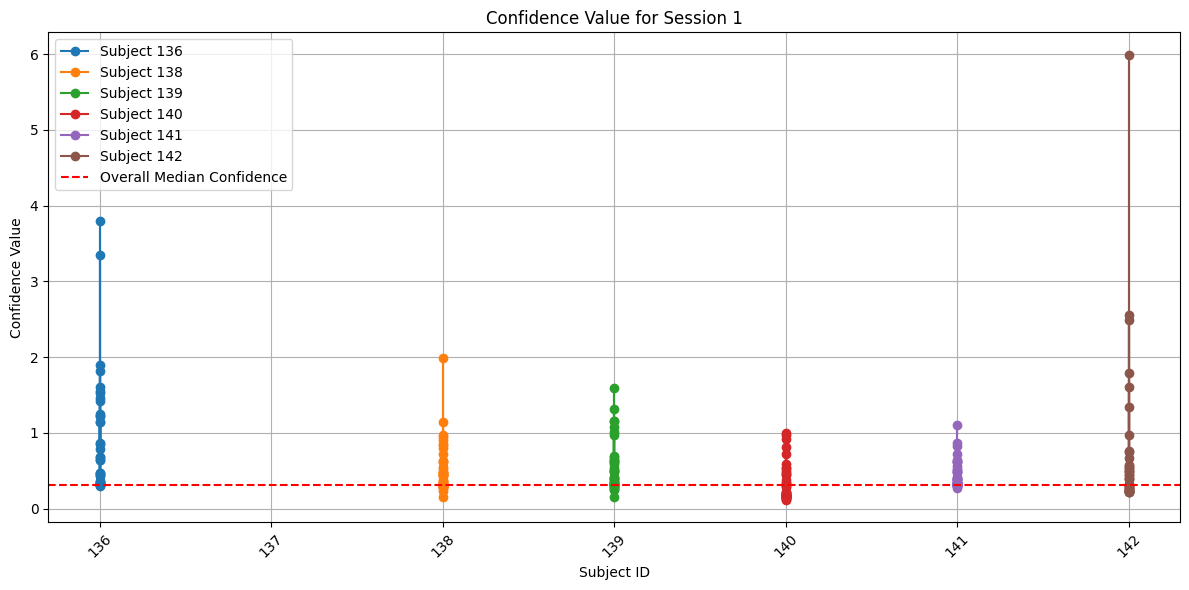

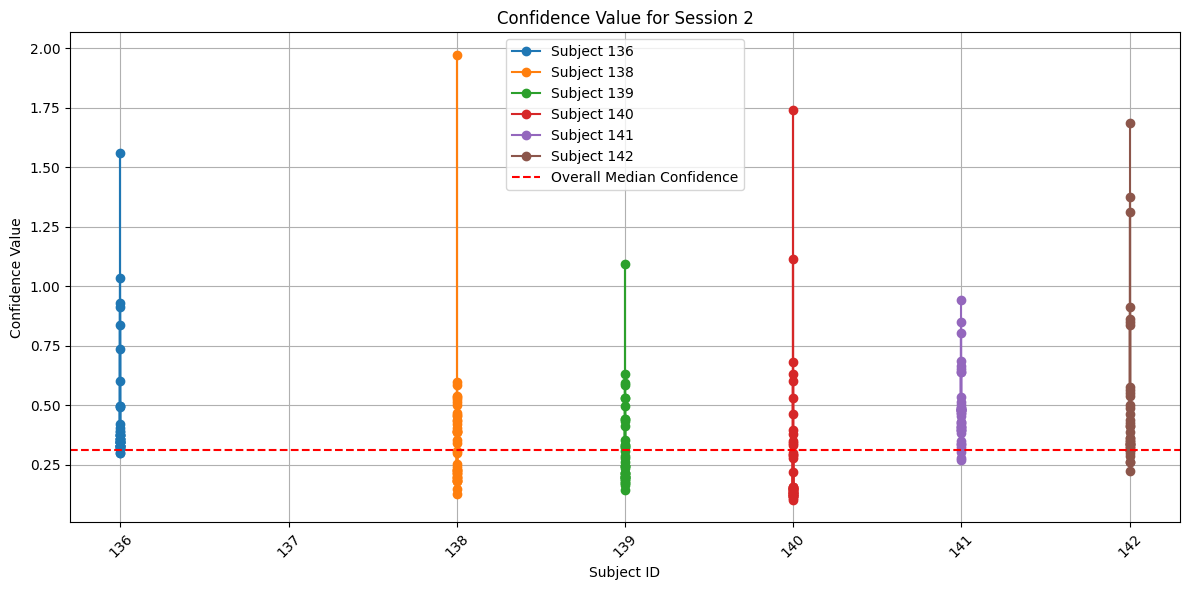

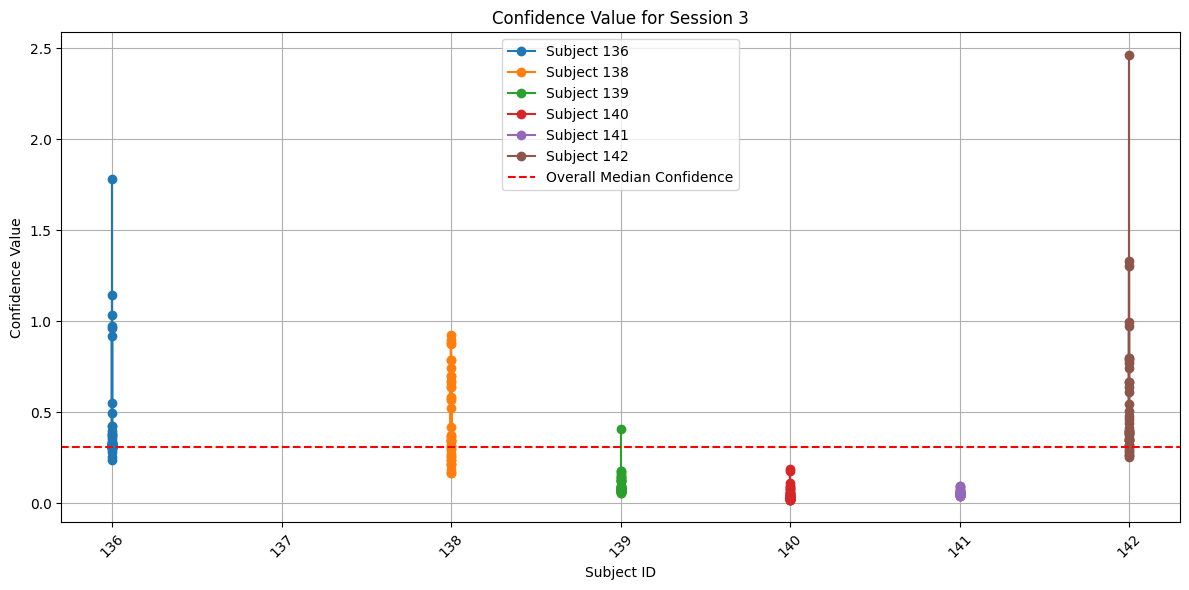

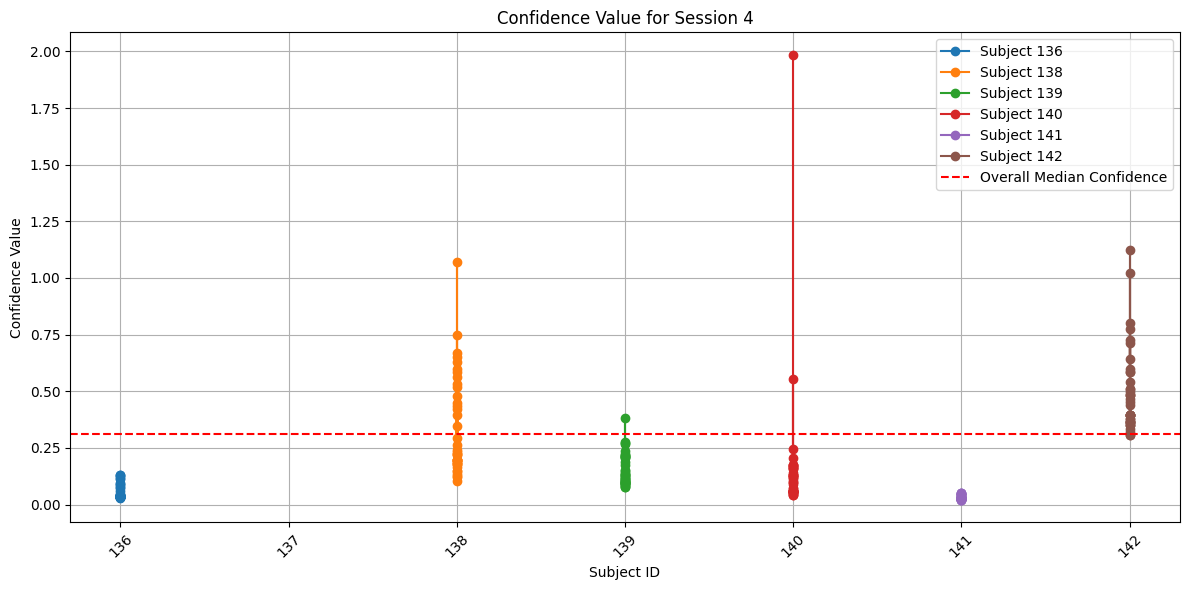

Individual confidence plots for each session have been saved.


In [20]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Load the decision time data
decision_time_path = '/work/student_folders/markus_folder/decision_time.csv'
decision_time_df = pd.read_csv(decision_time_path)

# Load the switch frequency data
switch_df_path = '/work/student_folders/markus_folder/switch_df.csv'
switch_df = pd.read_csv(switch_df_path)

# Merge the two dataframes on 'subject_id' and 'session'
merged_df = pd.merge(decision_time_df, switch_df, on=['subject_id', 'session'], how='outer')

# Check for negative values in the relevant columns
if (merged_df['decision_time'] < 0).any():
    print("Warning: Negative values found in 'decision_time'.")

if (merged_df['switch_frequency'] < 0).any():
    print("Warning: Negative values found in 'switch_frequency'.")

# Calculate confidence value by multiplying decision time with switch frequency
# Handle NaN values
merged_df['confidence_value'] = merged_df['decision_time'] * merged_df['switch_frequency']

# Check for NaN values in the confidence calculation
if merged_df['confidence_value'].isnull().any():
    print("Warning: NaN values generated in 'confidence_value'.")

# Replace any negative confidence values with NaN (to avoid plotting issues)
merged_df['confidence_value'] = merged_df['confidence_value'].where(merged_df['confidence_value'] >= 0)

# Calculate overall median confidence value for the entire dataset
overall_median_confidence = merged_df['confidence_value'].median()

# Create a new column for confidence (1 for below median, 2 for above)
merged_df['confidence'] = merged_df['confidence_value'].apply(lambda x: 1 if x < overall_median_confidence else 2)

# Prepare data for plotting
# Get unique sessions
sessions = merged_df['session'].unique()

# Create a plot for each session
for session in sessions:
    plt.figure(figsize=(12, 6))
    session_data = merged_df[merged_df['session'] == session]
    
    for subject_id in session_data['subject_id'].unique():
        subject_data = session_data[session_data['subject_id'] == subject_id]
        plt.plot(subject_data['subject_id'], subject_data['confidence_value'], marker='o', label=f'Subject {subject_id}')
    
    # Add a horizontal line for the overall median confidence
    plt.axhline(y=overall_median_confidence, color='r', linestyle='--', label='Overall Median Confidence')
    
    # Customize the plot
    plt.title(f'Confidence Value for Session {session}')
    plt.xlabel('Subject ID')
    plt.ylabel('Confidence Value')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Save the plot as an image file
    plot_output_path = os.path.join(os.path.dirname(decision_time_path), f'confidence_by_subject_session_{session}.png')
    plt.savefig(plot_output_path)
    plt.close()  # Close the figure to avoid displaying it multiple times

print("Individual confidence plots for each session have been saved.")


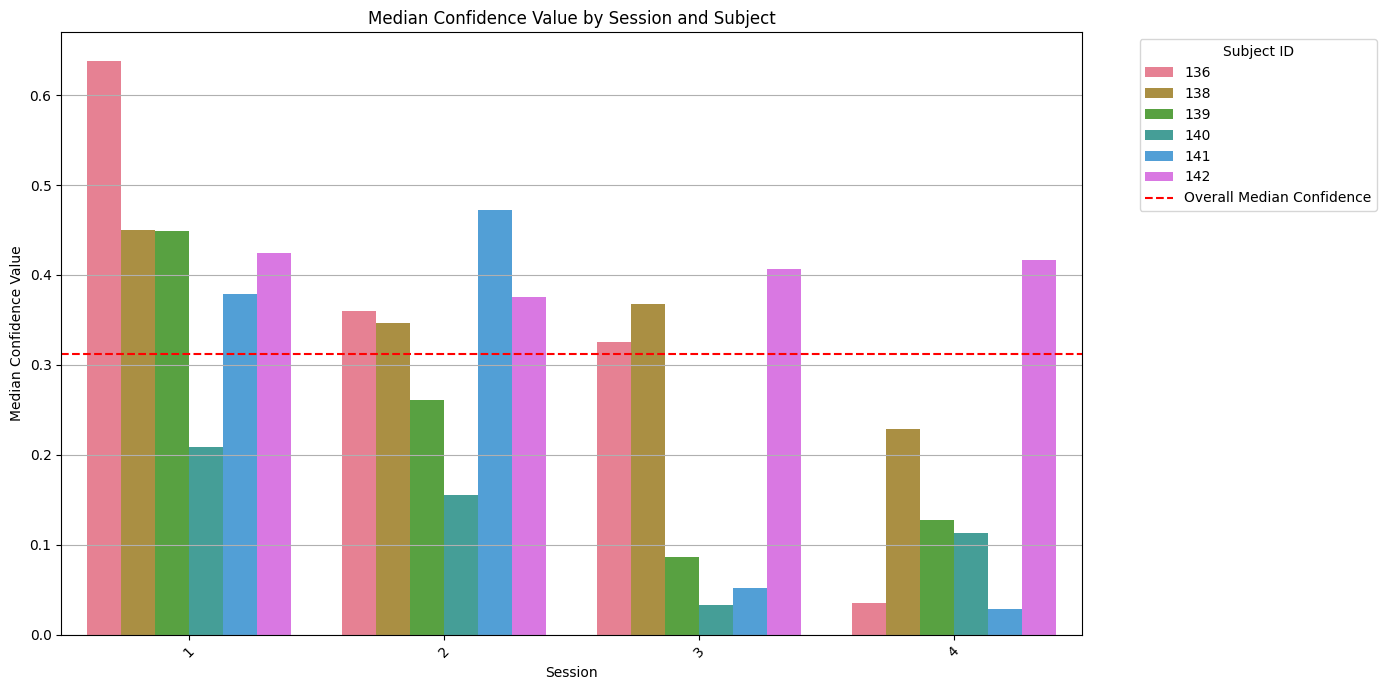

Grouped bar plot for median confidence by session and subject has been saved.


In [22]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Load the decision time data
decision_time_path = '/work/student_folders/markus_folder/decision_time.csv'
decision_time_df = pd.read_csv(decision_time_path)

# Load the switch frequency data
switch_df_path = '/work/student_folders/markus_folder/switch_df.csv'
switch_df = pd.read_csv(switch_df_path)

# Merge the two dataframes on 'subject_id' and 'session'
merged_df = pd.merge(decision_time_df, switch_df, on=['subject_id', 'session'], how='outer')

# Check for negative values in the relevant columns
if (merged_df['decision_time'] < 0).any():
    print("Warning: Negative values found in 'decision_time'.")

if (merged_df['switch_frequency'] < 0).any():
    print("Warning: Negative values found in 'switch_frequency'.")

# Calculate confidence value by multiplying decision time with switch frequency
# Handle NaN values
merged_df['confidence_value'] = merged_df['decision_time'] * merged_df['switch_frequency']

# Replace any negative confidence values with NaN (to avoid plotting issues)
merged_df['confidence_value'] = merged_df['confidence_value'].where(merged_df['confidence_value'] >= 0)

# Calculate overall median confidence value for the entire dataset
overall_median_confidence = merged_df['confidence_value'].median()

# Create a new column for confidence (1 for below median, 2 for above)
merged_df['confidence'] = merged_df['confidence_value'].apply(lambda x: 1 if x < overall_median_confidence else 2)

# Calculate median confidence value for each session and subject
median_confidence_per_subject_session = merged_df.groupby(['subject_id', 'session'])['confidence_value'].median().reset_index()

# Set up the color palette for different subjects
unique_subjects = median_confidence_per_subject_session['subject_id'].unique()
colors = sns.color_palette("husl", len(unique_subjects))

# Create a bar plot with different colors for each subject
plt.figure(figsize=(14, 7))
sns.barplot(x='session', y='confidence_value', hue='subject_id', data=median_confidence_per_subject_session, palette=colors)

# Customize the plot
plt.axhline(y=overall_median_confidence, color='r', linestyle='--', label='Overall Median Confidence')
plt.title('Median Confidence Value by Session and Subject')
plt.xlabel('Session')
plt.ylabel('Median Confidence Value')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Subject ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

# Save the plot as an image file
plot_output_path = os.path.join(os.path.dirname(decision_time_path), 'median_confidence_by_session_subject.png')
plt.savefig(plot_output_path)
plt.close()  # Close the figure to avoid displaying it multiple times

print("Grouped bar plot for median confidence by session and subject has been saved.")


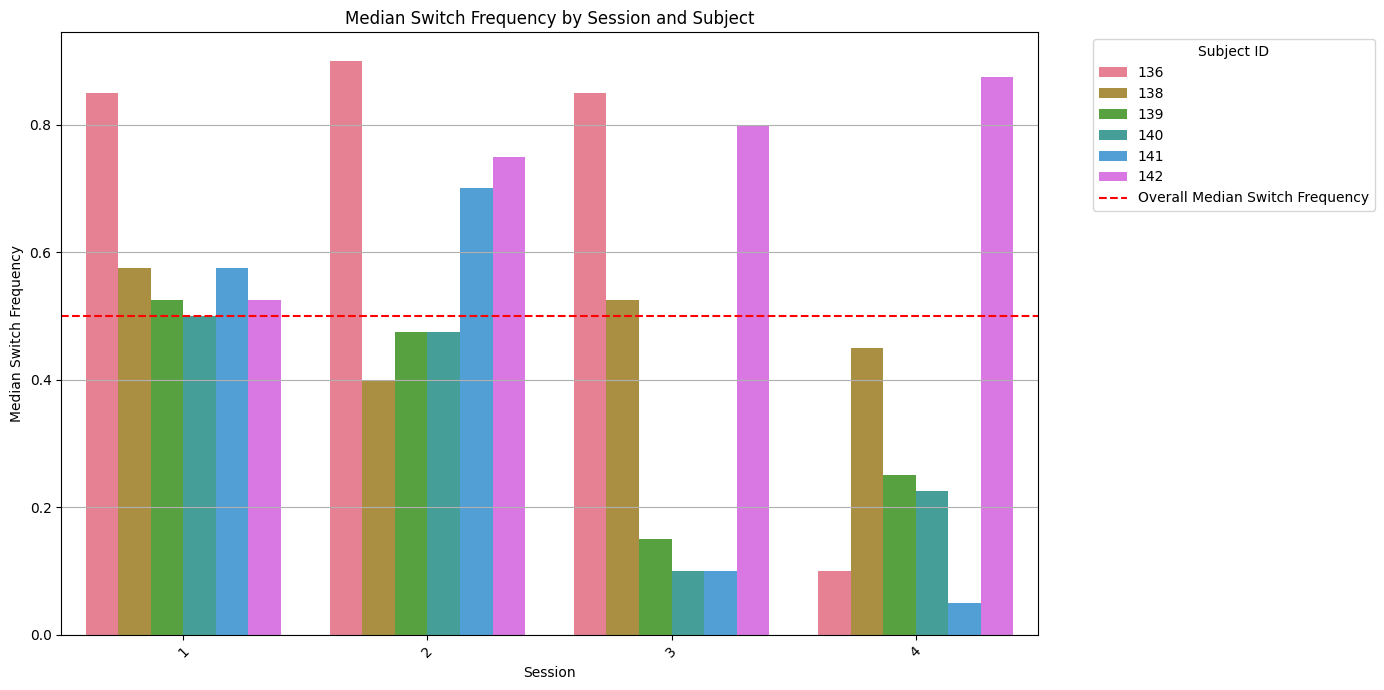

Grouped bar plot for median switch frequency by session and subject has been saved.


In [27]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Load the decision time data
decision_time_path = '/work/student_folders/markus_folder/decision_time.csv'
decision_time_df = pd.read_csv(decision_time_path)

# Load the switch frequency data
switch_df_path = '/work/student_folders/markus_folder/switch_df.csv'
switch_df = pd.read_csv(switch_df_path)

# Merge the two dataframes on 'subject_id' and 'session'
merged_df = pd.merge(decision_time_df, switch_df, on=['subject_id', 'session'], how='outer')

# Calculate the overall median switch frequency
overall_median_switch_frequency = merged_df['switch_frequency'].median()

# Calculate median switch frequency for each session and subject
median_switch_frequency_per_subject_session = merged_df.groupby(['subject_id', 'session'])['switch_frequency'].median().reset_index()

# Set up the color palette for different subjects
unique_subjects = median_switch_frequency_per_subject_session['subject_id'].unique()
colors = sns.color_palette("husl", len(unique_subjects))

# Create a bar plot with different colors for each subject
plt.figure(figsize=(14, 7))
bar_plot = sns.barplot(x='session', y='switch_frequency', hue='subject_id', data=median_switch_frequency_per_subject_session, palette=colors)

# Customize the plot
plt.title('Median Switch Frequency by Session and Subject')
plt.xlabel('Session')
plt.ylabel('Median Switch Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Add a horizontal line for overall median switch frequency
plt.axhline(y=overall_median_switch_frequency, color='r', linestyle='--', label='Overall Median Switch Frequency')

# Add legend for subject IDs and overall median line
plt.legend(title='Subject ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

# Save the plot as an image file
plot_output_path = os.path.join(os.path.dirname(decision_time_path), 'median_switch_frequency_by_session_subject.png')
plt.savefig(plot_output_path)
plt.close()  # Close the figure to avoid displaying it multiple times

print("Grouped bar plot for median switch frequency by session and subject has been saved.")


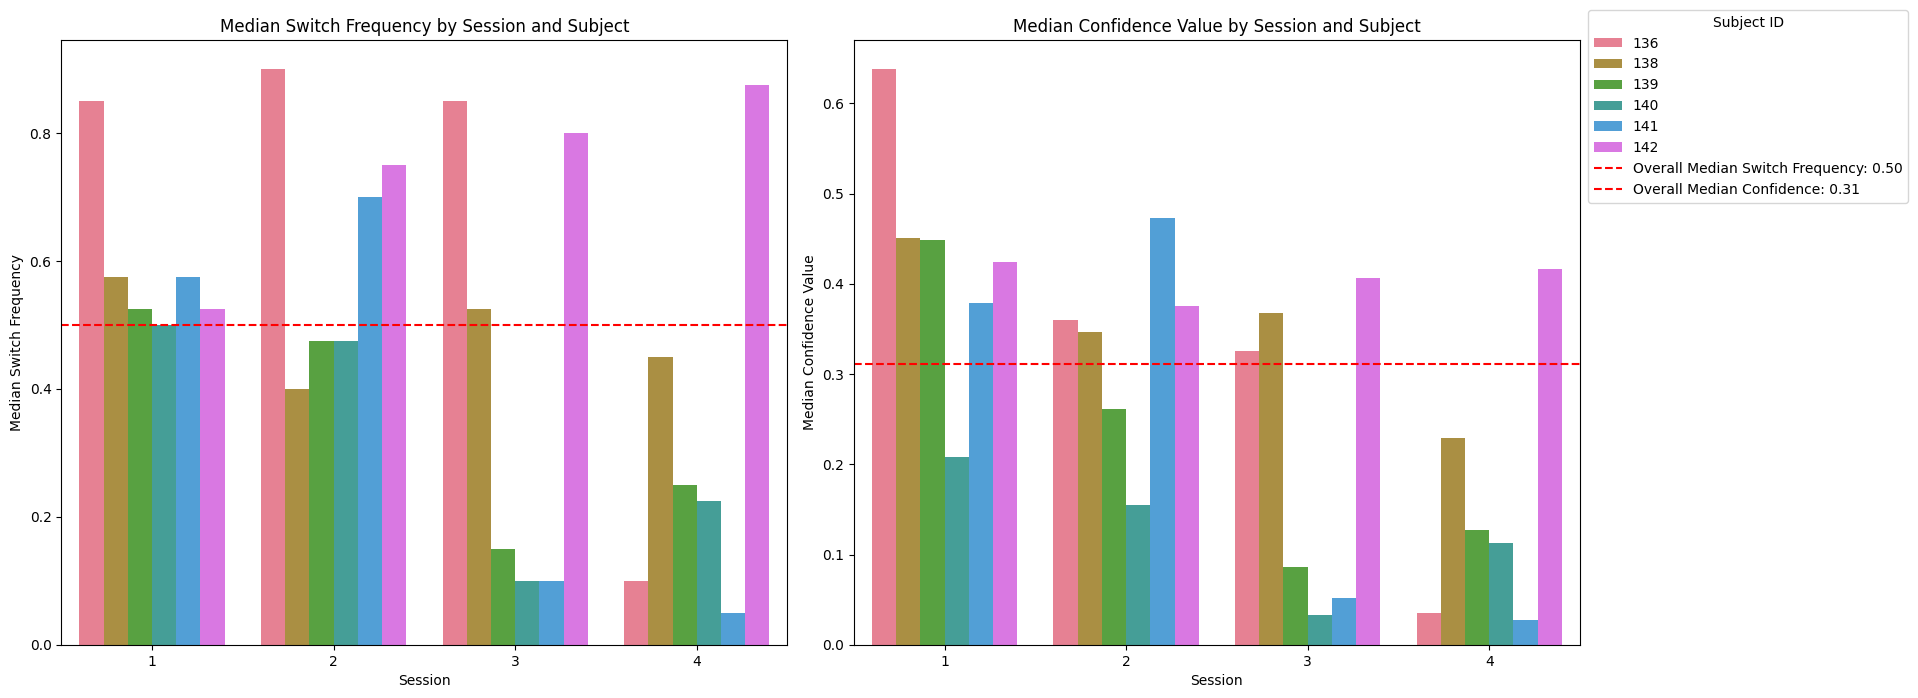

Grouped bar plots for median switch frequency and median confidence by session and subject have been saved.


In [49]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Load the decision time data
decision_time_path = '/work/student_folders/markus_folder/decision_time.csv'
decision_time_df = pd.read_csv(decision_time_path)

# Load the switch frequency data
switch_df_path = '/work/student_folders/markus_folder/switch_df.csv'
switch_df = pd.read_csv(switch_df_path)

# Merge the two dataframes on 'subject_id' and 'session'
merged_df = pd.merge(decision_time_df, switch_df, on=['subject_id', 'session'], how='outer')

# Check for negative values in the relevant columns
if (merged_df['decision_time'] < 0).any():
    print("Warning: Negative values found in 'decision_time'.")

if (merged_df['switch_frequency'] < 0).any():
    print("Warning: Negative values found in 'switch_frequency'.")

# Calculate confidence value by multiplying decision time with switch frequency
# Handle NaN values
merged_df['confidence_value'] = merged_df['decision_time'] * merged_df['switch_frequency']

# Replace any negative confidence values with NaN (to avoid plotting issues)
merged_df['confidence_value'] = merged_df['confidence_value'].where(merged_df['confidence_value'] >= 0)

# Calculate overall median confidence value for the entire dataset
overall_median_confidence = merged_df['confidence_value'].median()

# Create a new column for confidence (1 for below median, 2 for above)
merged_df['confidence'] = merged_df['confidence_value'].apply(lambda x: 1 if x < overall_median_confidence else 2)

# Calculate median confidence value for each session and subject
median_confidence_per_subject_session = merged_df.groupby(['subject_id', 'session'])['confidence_value'].median().reset_index()

# Calculate overall median switch frequency
overall_median_switch_frequency = merged_df['switch_frequency'].median()

# Calculate median switch frequency for each session and subject
median_switch_frequency_per_subject_session = merged_df.groupby(['subject_id', 'session'])['switch_frequency'].median().reset_index()

# Set up the color palette for different subjects
unique_subjects = median_confidence_per_subject_session['subject_id'].unique()
colors = sns.color_palette("husl", len(unique_subjects))

# Create subplots for side-by-side bar plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))  # Increased width for better spacing

# Bar plot for median switch frequency
sns.barplot(x='session', y='switch_frequency', hue='subject_id', data=median_switch_frequency_per_subject_session, palette=colors, ax=axes[0])
axes[0].axhline(y=overall_median_switch_frequency, color='r', linestyle='--', label='Overall Median Switch Frequency: {:.2f}'.format(overall_median_switch_frequency))
axes[0].set_title('Median Switch Frequency by Session and Subject')
axes[0].set_xlabel('Session')
axes[0].set_ylabel('Median Switch Frequency')

# Bar plot for median confidence
sns.barplot(x='session', y='confidence_value', hue='subject_id', data=median_confidence_per_subject_session, palette=colors, ax=axes[1])
axes[1].axhline(y=overall_median_confidence, color='r', linestyle='--', label='Overall Median Confidence: {:.2f}'.format(overall_median_confidence))
axes[1].set_title('Median Confidence Value by Session and Subject')
axes[1].set_xlabel('Session')
axes[1].set_ylabel('Median Confidence Value')

# Create a custom legend for both plots
handles, labels = axes[0].get_legend_handles_labels()  # Get legend from the first plot
# Create a dictionary to track labels to avoid duplicates
label_dict = {label: handle for label, handle in zip(labels, handles)}

# Add overall median confidence and switch frequency as separate entries
label_dict['Overall Median Confidence'] = plt.Line2D([0], [0], color='red', linestyle='--', label='Overall Median Confidence: {:.2f}'.format(overall_median_confidence))


# Set legend for both plots
fig.legend(handles=list(label_dict.values()), title='Subject ID', loc='upper right', bbox_to_anchor=(1.2, 1))  # Moved legend slightly left

# Remove legend from the subplots to avoid duplication
axes[0].legend().remove()
axes[1].legend().remove()

# Adjust spacing between plots
plt.subplots_adjust(wspace=0.4)  # Increase space between the two subplots

# Show the plot
plt.tight_layout()
plt.show()

# Save the plot as an image file
plot_output_path = os.path.join(os.path.dirname(decision_time_path), 'median_switch_frequency_and_confidence_by_session_subject.png')
plt.savefig(plot_output_path)
plt.close()  # Close the figure to avoid displaying it multiple times

print("Grouped bar plots for median switch frequency and median confidence by session and subject have been saved.")


In [55]:
import pandas as pd
import os

# Load the decision time data
decision_time_path = '/work/student_folders/markus_folder/decision_time.csv'
decision_time_df = pd.read_csv(decision_time_path)

# Load the switch frequency data
switch_df_path = '/work/student_folders/markus_folder/switch_df.csv'
switch_df = pd.read_csv(switch_df_path)

# Merge the two dataframes on 'subject_id' and 'session'
merged_df = pd.merge(decision_time_df, switch_df, on=['subject_id', 'session'], how='outer')

# Check for negative values in the relevant columns
if (merged_df['decision_time'] < 0).any():
    print("Warning: Negative values found in 'decision_time'.")

if (merged_df['switch_frequency'] < 0).any():
    print("Warning: Negative values found in 'switch_frequency'.")

# Calculate confidence value by multiplying decision time with switch frequency
# Handle NaN values
merged_df['confidence_value'] = merged_df['decision_time'] * merged_df['switch_frequency']

# Replace any negative confidence values with NaN (to avoid plotting issues)
merged_df['confidence_value'] = merged_df['confidence_value'].where(merged_df['confidence_value'] >= 0)

# Calculate overall median confidence value for the entire dataset
overall_median_confidence = merged_df['confidence_value'].median()

# Create a new column for confidence (1 for below median, 2 for above)
merged_df['confidence'] = merged_df['confidence_value'].apply(lambda x: 1 if x < overall_median_confidence else 2)

# Select the relevant columns for the new CSV
new_output_df = merged_df[['subject_id', 'session', 'decision_time', 'switch_frequency', 
                            'confidence_value', 'confidence', 'onset_decks']]

# Save to CSV in the same directory as decision_time.csv
new_output_path = os.path.join(os.path.dirname(decision_time_path), 'detailed_confidence_data.csv')
new_output_df.to_csv(new_output_path, index=False)

print("The new CSV file containing the selected columns has been saved as 'detailed_confidence_data.csv'.")


The new CSV file containing the selected columns has been saved as 'detailed_confidence_data.csv'.
